In [1]:

import os
import matplotlib.pyplot as plt
# Load standard libs
import numpy as np
from importlib import reload
import pandas as pd


In [2]:
%load_ext autoreload  
%autoreload 2

In [3]:
nameExp = "current_LogLoss_Transformer_Dense_Transformer"
nameExp_Transformer = "current_LogLoss_Transformer_Dense_Transformer"
nameExp_LSTM = "current_LogLoss_Transformer_Dense_LSTM"

nameExp = "smallSigma_GaussianHeatMap_LinearLoss_Transformer"
nameExp_Bayes = "current_LogLoss_Transformer_Dense_Transformer"

#nameExp = "projected_LinearLoss_Dense_Transformer"


In [4]:
jsonPath = None
windowSizeMS = [108]
mode = "ann"
target = "pos"
phase = "pre"
nEpochs = 200 
mouse = "1199"
manipe = "PAG"

In [5]:
import neuroencoders.utils.MOBS_Functions as mf

Dir = mf.path_for_experiments_df('Sub', nameExp)
Dir_Transformer = mf.path_for_experiments_df('Sub', nameExp_Transformer)
Dir_LSTM = mf.path_for_experiments_df('Sub', nameExp_LSTM)

2025-09-05 16:12:01.992984: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-09-05 16:12:01.993020: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-09-05 16:12:01.994759: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [6]:
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
import tensorflow as tf

# Hide GPU from visible devices
tf.config.set_visible_devices([], 'GPU')

In [7]:
deviceName = "cpu"
Mouse_Results = mf.Mouse_Results(Dir, mouse_name=mouse, manipe=manipe, target=target, 
                                                        nameExp=nameExp, nEpochs=nEpochs, phase=phase, 
                                                        deviceName=deviceName, windows=windowSizeMS,
                                                        isTransformer = "LSTM" not in nameExp, denseweight= False, 
                                                        transform_w_log = False,
                                                        which = "both",
                                                        isPredLoss = False,
                                                        GaussianHeatmap = True,
                                                        # bayes_project_path = nameExp_Bayes,
                                                        )

Path for 1199 found: /media/mickey/DataTheotime210/DimaERC2/neuroencoders_1021/_work/M1199_PAG
Windows found for 1199: ['108']
/media/mickey/DataTheotime210/DimaERC2/neuroencoders_1021/_work/M1199_PAG/smallSigma_GaussianHeatMap_LinearLoss_Transformer/results
extending trainEpochs with lossPredSetEpochs as you're not using predLoss
found data_helper, using its custom lines
Linearization points have been created before


/home/mickey/Documents/Theotime/neuroEncoders/.venv/lib/python3.10/site-packages/tables/attributeset.py:295: DataTypeWarning: Unsupported type for attribute 'MATLAB_fields' in node 'optional'. Offending HDF5 class: 9
  value = self._g_getattr(self._v_node, name)
/home/mickey/Documents/Theotime/neuroEncoders/.venv/lib/python3.10/site-packages/tables/attributeset.py:295: DataTypeWarning: Unsupported type for attribute 'MATLAB_fields' in node 'behavior'. Offending HDF5 class: 9
  value = self._g_getattr(self._v_node, name)


Setting up GaussianHeatmapLayer...
Occupation map: 442 zero-occupation bins, 41 low-density bins (below 8.5794e-01) in allowed zones.
Weight map: Removed 34 low-density bins adjacent to forbidden zones
UMazeProjectionLayer initialized with params: {'x_min': 0.0, 'x_max': 1.0, 'y_min': 0.0, 'y_max': 1.0, 'gap_x_min': 0.35, 'gap_x_max': 0.65, 'gap_y_min': 0.75}
Using Transformer architecture !
Reading saved cluster csv file


100%|██████████| 4/4 [00:09<00:00,  2.34s/it]

finished reading
======================M1199=======================
Mouse_Results for 1199 (PAG)
Experiment: smallSigma_GaussianHeatMap_LinearLoss_Transformer
Target: pos
Phase: pre
Path: /media/mickey/DataTheotime210/DimaERC2/neuroencoders_1021/_work/M1199_PAG
Windows: 108


## mobs_function

##### plotting logits stuff for heatmap

In [92]:
import dill as pickle

In [93]:
with open(os.path.join(Mouse_Results.folderResult, "108", "decoding_results_pre.pkl"), "rb") as f:
    decoding_results = pickle.load(f)

In [94]:
decoding_results.keys()

dict_keys(['featurePred', 'featureTrue', 'times', 'predLoss', 'posLoss', 'posIndex', 'speedMask', 'uncertaintyLoss', 'indexInDat', 'projPred', 'projTruePos', 'linearPred', 'linearTrue', 'logits_hw', 'var_total', 'Hn', 'maxp', 'T_scaling'])

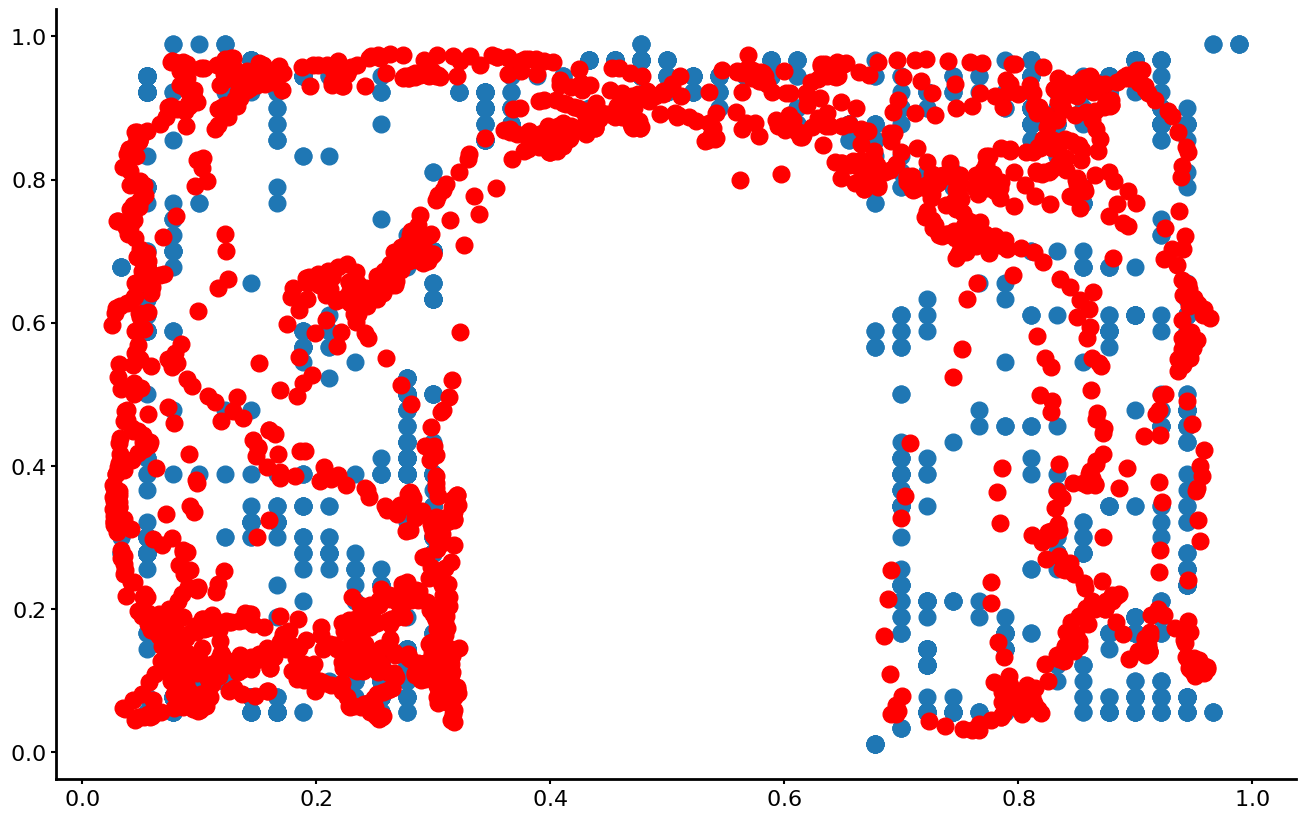

In [95]:
plt.scatter(decoding_results["featurePred"][:,0], decoding_results["featurePred"][:,1])
plt.scatter(decoding_results["featureTrue"][:,0], decoding_results["featureTrue"][:,1], c= "r")

In [96]:
logits_hw = decoding_results["logits_hw"]
entropy_hw = decoding_results["Hn"]
net = Mouse_Results.ann['108']
heatmap_layer = net.GaussianHeatmap
truePos = decoding_results["featureTrue"]

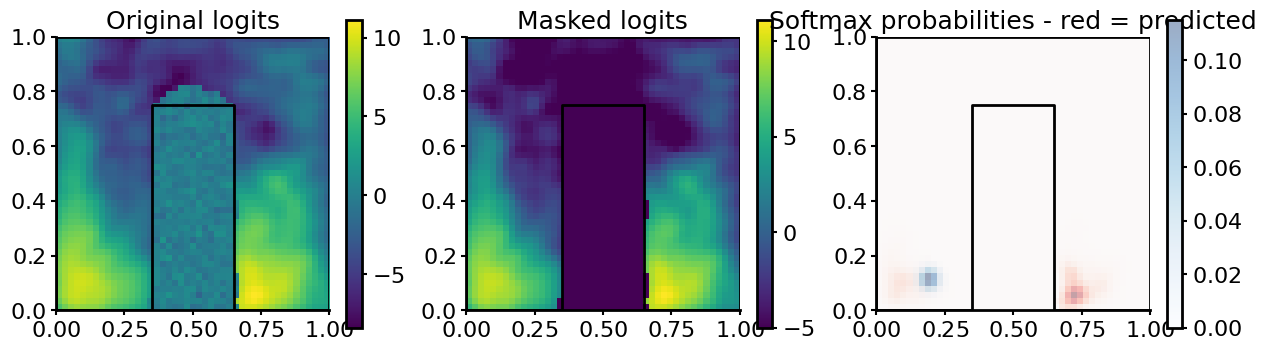

Forbidden probability sum: 0.000000
Allowed probability sum: 1.000000
Target - forbidden mass: 0.000000
Target - allowed mass: 1.000000


In [97]:
# Assume logits_hw: [B,H,W], target_hw: [B,H,W], heatmap_layer instance exists
from neuroencoders.utils.global_classes import MAZE_COORDS
B, H, W = logits_hw.shape

# 1️⃣ Mask forbidden logits
masked_logits = tf.where(heatmap_layer.forbid_mask_tf[None] > 0, heatmap_layer.NEG, logits_hw)

# 2️⃣ Softmax over allowed bins
logits_flat = tf.reshape(masked_logits, [B, H*W])
probs_flat = tf.nn.softmax(logits_flat, axis=-1)
probs = tf.reshape(probs_flat, [B, H, W])

# 3️⃣ Gaussian targets for comparison
target_hw = heatmap_layer.gaussian_heatmap_targets(truePos)  # batch-size slice

# 4️⃣ Plot one example
i = np.random.randint(0, B-1)  # first example in batch

plt.figure(figsize=(15,4))

plt.subplot(1,3,1)
plt.title("Original logits")
plt.plot(MAZE_COORDS[:,0], MAZE_COORDS[:,1], 'k-', lw=2)
plt.imshow(logits_hw[i], origin='lower', extent = (0,1,0,1))
plt.colorbar()

plt.subplot(1,3,2)
plt.title("Masked logits")
plt.plot(MAZE_COORDS[:,0], MAZE_COORDS[:,1], 'k-', lw=2)
plt.imshow(masked_logits[i], origin='lower', vmin=-5, extent= (0,1,0,1))
plt.colorbar()

plt.subplot(1,3,3)
plt.title("Softmax probabilities - red = predicted")
overlap = np.minimum(probs[i], target_hw.numpy()[i])
plt.plot(MAZE_COORDS[:,0], MAZE_COORDS[:,1], 'k-', lw=2)

plt.imshow(probs[i], origin='lower', alpha = 0.6, cmap = "Reds", extent = (0,1,0,1))
plt.imshow(target_hw.numpy()[i], origin='lower', alpha=0.4, cmap = "Blues", extent = (0,1,0,1))
# plt.imshow(overlap, cmap='YlOrBr', origin = "lower", alpha=0.2)
plt.colorbar()

plt.show()

# Optional: check forbidden bins probability sum
forbid_prob_sum = tf.reduce_sum(probs[i] * heatmap_layer.forbid_mask_tf)
allowed_prob_sum = tf.reduce_sum(probs[i] * (1.0 - heatmap_layer.forbid_mask_tf))
print(f"Forbidden probability sum: {forbid_prob_sum.numpy():.6f}")
print(f"Allowed probability sum: {allowed_prob_sum.numpy():.6f}")

# Optional: check target mass
forbid_target_sum = tf.reduce_sum(target_hw[i] * heatmap_layer.forbid_mask_tf)
allowed_target_sum = tf.reduce_sum(target_hw[i] * (1.0 - heatmap_layer.forbid_mask_tf))
print(f"Target - forbidden mass: {forbid_target_sum.numpy():.6f}")
print(f"Target - allowed mass: {allowed_target_sum.numpy():.6f}")


In [98]:
truePos.shape
probs.shape

TensorShape([2048, 45, 45])

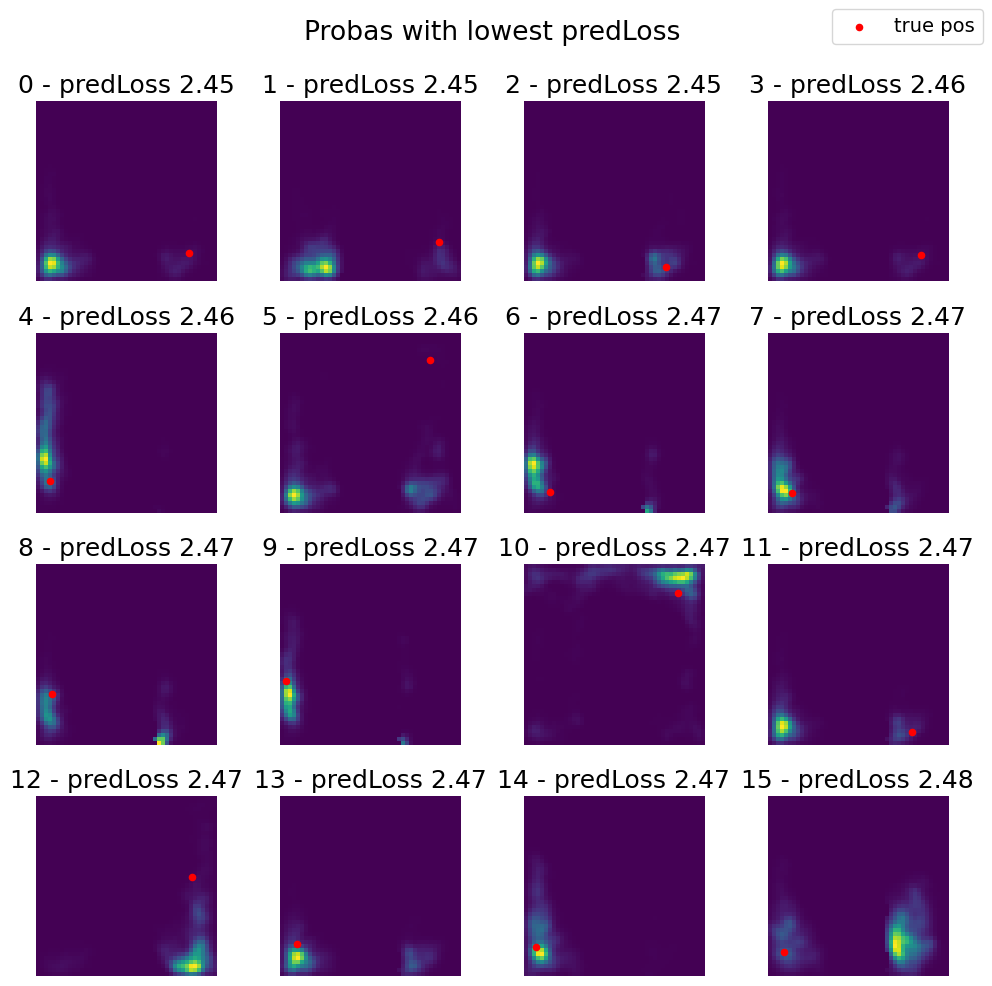

In [99]:
predLoss = decoding_results["predLoss"].reshape(-1)

num_subplots = 16
# get 10 smallest predloss
predLoss_sorted_indices = np.argsort(predLoss)[:num_subplots].flatten()

# plot the first 16 imshow of logits_hw 
fig, axs = plt.subplots(4, 4, figsize=(10, 10))
for i in range(num_subplots):
    ax = axs[i // 4, i % 4]
    ax.imshow(probs[predLoss_sorted_indices[i], :, :], origin='lower', vmin=0, extent = (0,1,0,1), label = "scaled proba")
    ax.scatter(truePos[predLoss_sorted_indices[i],0], truePos[predLoss_sorted_indices[i],1], c='r', s=20, label = "true pos")
    ax.set_title(f'{i} - predLoss {predLoss[predLoss_sorted_indices[i]]:.2f}')
    ax.axis('off')
fig.suptitle("Probas with lowest predLoss")
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right')

plt.tight_layout()
plt.show()

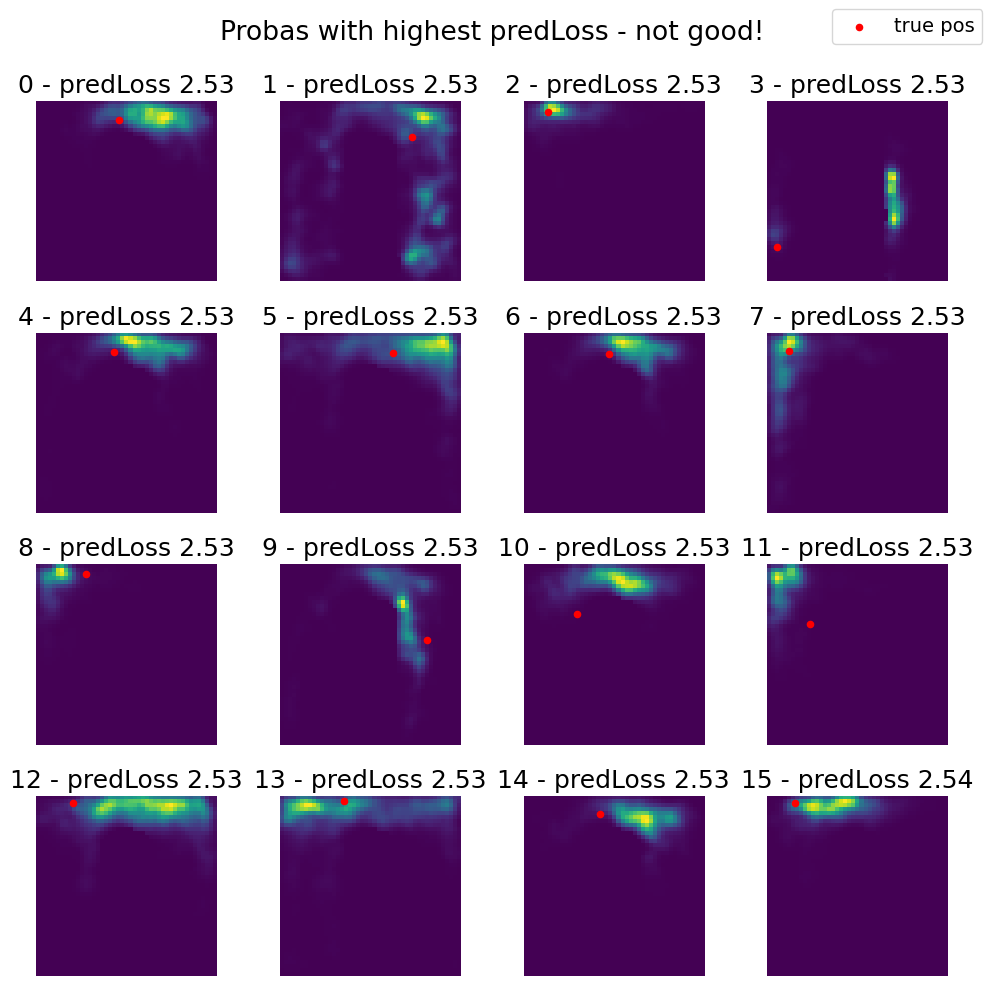

In [100]:
predLoss = decoding_results["predLoss"].reshape(-1)

num_subplots = 16
# get 10 smallest predloss
predLoss_sorted_indices = np.argsort(predLoss)[-num_subplots:].flatten()

# plot the first 16 imshow of logits_hw 
fig, axs = plt.subplots(4, 4, figsize=(10, 10))
for i in range(num_subplots):
    ax = axs[i // 4, i % 4]
    ax.imshow(probs[predLoss_sorted_indices[i], :, :], origin='lower', vmin=0, extent = (0,1,0,1), label = "scaled proba")
    ax.scatter(truePos[predLoss_sorted_indices[i],0], truePos[predLoss_sorted_indices[i],1], c='r', s=20, label = "true pos")
    ax.set_title(f'{i} - predLoss {predLoss[predLoss_sorted_indices[i]]:.2f}')
    ax.axis('off')
fig.suptitle("Probas with highest predLoss - not good!")
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right')

plt.tight_layout()
plt.show()

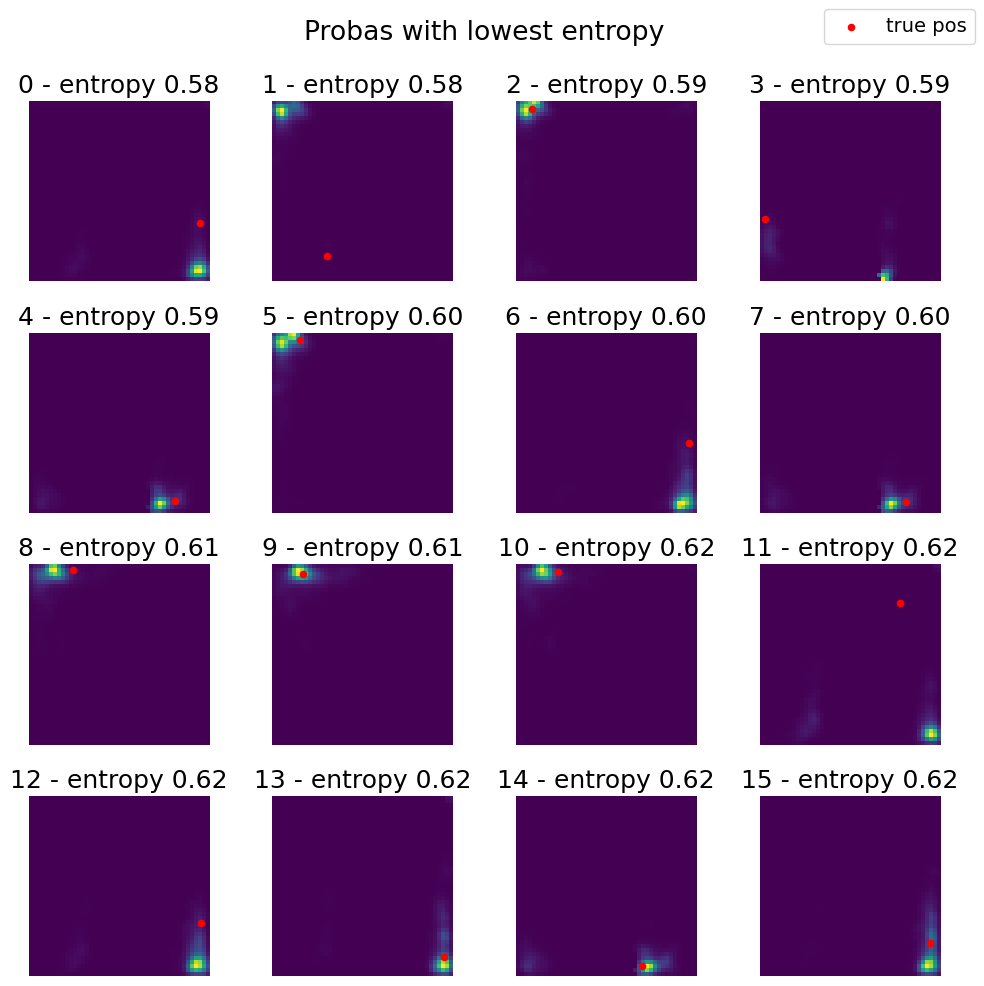

In [101]:
num_subplots = 16
# get 10 smallest entropy
entropy_sorted_indices = tf.argsort(entropy_hw)[:num_subplots].numpy() 

# plot the first 16 imshow of logits_hw 
fig, axs = plt.subplots(4, 4, figsize=(10, 10))
for i in range(num_subplots):
    ax = axs[i // 4, i % 4]
    ax.imshow(probs[entropy_sorted_indices[i], :, :], origin='lower', vmin=0, extent = (0,1,0,1), label = "scaled proba")
    ax.scatter(truePos[entropy_sorted_indices[i],0], truePos[entropy_sorted_indices[i],1], c='r', s=20, label = "true pos")
    ax.set_title(f'{i} - entropy {entropy_hw[entropy_sorted_indices[i]]:.2f}')
    ax.axis('off')
fig.suptitle("Probas with lowest entropy")
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right')

plt.tight_layout()
plt.show()

In [102]:

# Compute KL loss
batch_pos = decoding_results["featureTrue"]
kl_loss = heatmap_layer.safe_kl_heatmap_loss(logits_hw, target_hw)
print("KL loss:", kl_loss.numpy())

# Check that forbidden bins have zero probability
masked_logits = tf.where(heatmap_layer.forbid_mask_tf[None]>0, heatmap_layer.NEG, logits_hw)
probs = tf.nn.softmax(tf.reshape(masked_logits, [len(batch_pos),45*45]), axis=-1)
probs = tf.reshape(probs, [len(batch_pos),45,45])
probs *= (1.0 - heatmap_layer.forbid_mask_tf[None])
probs /= tf.reduce_sum(probs, axis=[1,2], keepdims=True)
print("Max probability in forbidden area (should be 0):",
      tf.reduce_max(probs * heatmap_layer.forbid_mask_tf[None]).numpy())

KL loss: 3.824944
Max probability in forbidden area (should be 0): 0.0


In [103]:
probs = tf.nn.softmax(logits_hw, axis = -1).numpy()

In [104]:
probs.max()

0.70828384

In [105]:
sample_idx = 10
probs = tf.nn.softmax(tf.reshape(logits_hw[sample_idx], [-1]))
print("Max prob:", tf.reduce_max(probs).numpy())
topk = tf.math.top_k(probs, k=10)
print("Top 10 probs:", topk.values.numpy())


Max prob: 0.01607581
Top 10 probs: [0.01607581 0.01577259 0.01567167 0.01521763 0.01489115 0.01486329
 0.01416695 0.01416348 0.01413361 0.01401411]


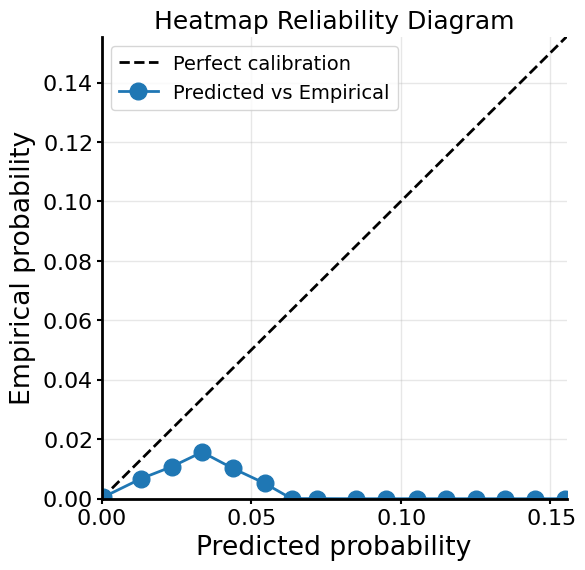

In [36]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

def heatmap_reliability_plot(logits_hw, target_hw, n_bins=10, forbid_mask=None):
    """
    Creates a reliability diagram for heatmap predictions.

    Args:
        logits_hw: [B, H, W] predicted logits
        target_hw: [B, H, W] target heatmaps (normalized)
        n_bins: number of probability bins
        forbid_mask: [H, W] 1 for forbidden bins, 0 otherwise (optional)
    """
    B, H, W = logits_hw.shape

    # Mask forbidden bins if provided
    if forbid_mask is not None:
        logits_hw = tf.where(forbid_mask[None] > 0, -1e5, logits_hw)
    
    # Flatten spatial dimensions
    probs_flat = tf.reshape(tf.nn.softmax(tf.reshape(logits_hw, [B, H*W]), axis=-1), [B, H*W])
    targets_flat = tf.reshape(target_hw, [B, H*W])

    probs_flat = probs_flat.numpy()
    targets_flat = targets_flat.numpy()

    # Define bins
    bin_edges = np.linspace(0.0, 1.0, n_bins + 1)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

    avg_pred_probs = []
    avg_true_probs = []

    for i in range(n_bins):
        mask = (probs_flat >= bin_edges[i]) & (probs_flat < bin_edges[i+1])
        if np.sum(mask) > 0:
            avg_pred_probs.append(np.mean(probs_flat[mask]))
            avg_true_probs.append(np.mean(targets_flat[mask]))
        else:
            avg_pred_probs.append(bin_centers[i])
            avg_true_probs.append(0.0)

    # Plo
    plt.figure(figsize=(6,6))
    plt.plot([0,1], [0,1], 'k--', label="Perfect calibration")
    plt.plot(avg_pred_probs, avg_true_probs, 'o-', label="Predicted vs Empirical")
    plt.xlim(0, probs_flat.max() + 0.05)
    plt.ylim(0, probs_flat.max() + 0.05)

    plt.xlabel("Predicted probability")
    plt.ylabel("Empirical probability")
    plt.title("Heatmap Reliability Diagram")
    plt.legend()
    plt.grid(True)
    plt.show()
    
# Usage
heatmap_reliability_plot(logits_hw, target_hw, n_bins=100, forbid_mask=net.GaussianHeatmap.forbid_mask_tf)


In [124]:
decoding_results.keys()

dict_keys(['featurePred', 'featureTrue', 'times', 'predLoss', 'posLoss', 'posIndex', 'speedMask', 'uncertaintyLoss', 'indexInDat', 'projPred', 'projTruePos', 'linearPred', 'linearTrue', 'logits_hw', 'var_total', 'Hn', 'maxp', 'T_scaling'])

In [133]:
x = decoding_results["predLoss"].reshape(-1)
y = kl_loss.numpy()
p = np.polyfit(x, y, 2)

/home/mickey/Documents/Theotime/neuroEncoders/.venv/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3579: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


KL loss for ann: 3.824944


/home/mickey/Documents/Theotime/neuroEncoders/.venv/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3579: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/mickey/Documents/Theotime/neuroEncoders/.venv/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3579: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


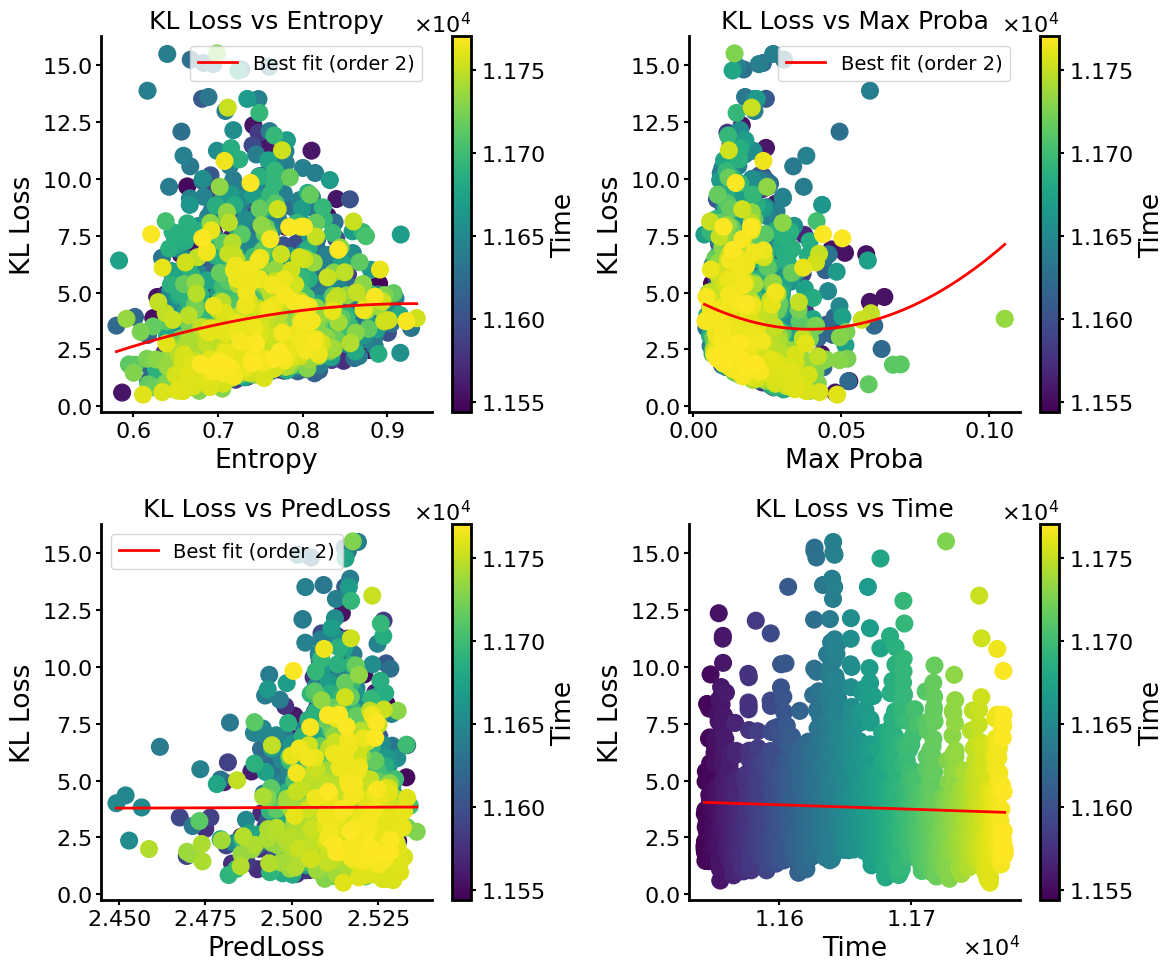

In [140]:
import numpy as np

# Compute KL loss
batch_pos = decoding_results["featureTrue"]
kl_loss = Mouse_Results.ann['108'].GaussianHeatmap.safe_kl_heatmap_loss(logits_hw, target_hw, return_batch = True)
print("KL loss for ann:", kl_loss.numpy().mean())
# plot 4 subplots of kl_loss vs : entropy, predLoss, max_proba, time
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

time = decoding_results["times"]

# Scatter points colored by time
sc = axs[0,0].scatter(decoding_results["Hn"], kl_loss.numpy(), c=decoding_results["times"], cmap='viridis')
axs[0,0].set_xlabel("Entropy")
axs[0,0].set_ylabel("KL Loss")
axs[0,0].set_title("KL Loss vs Entropy")
plt.colorbar(sc, ax=axs[0,0], label="Time")
# Best fit line (order 2)
x = decoding_results["Hn"]
y = kl_loss.numpy()
p = np.polyfit(x, y, 2)
x_fit = np.linspace(x.min(), x.max(), 100)
y_fit = np.polyval(p, x_fit)
axs[0,0].plot(x_fit, y_fit, 'r-', label="Best fit (order 2)")
axs[0,0].legend()

sc = axs[0,1].scatter(max_proba, kl_loss.numpy(), c=decoding_results["times"], cmap='viridis')
axs[0,1].set_xlabel("Max Proba")
axs[0,1].set_ylabel("KL Loss")
axs[0,1].set_title("KL Loss vs Max Proba")
plt.colorbar(sc, ax=axs[0,1], label="Time")
x = max_proba
y = kl_loss.numpy()
p = np.polyfit(x, y, 2)
x_fit = np.linspace(x.min(), x.max(), 100)
y_fit = np.polyval(p, x_fit)
axs[0,1].plot(x_fit, y_fit, 'r-', label="Best fit (order 2)")
axs[0,1].legend()

# predLoss plot spans both columns in second row
sc = axs[1,0].scatter(decoding_results["predLoss"], kl_loss.numpy(), c=decoding_results["times"], cmap='viridis')
axs[1,0].set_xlabel("PredLoss")
axs[1,0].set_ylabel("KL Loss")
axs[1,0].set_title("KL Loss vs PredLoss")
plt.colorbar(sc, ax=axs[1,0], label="Time")
x = decoding_results["predLoss"].flatten()
y = kl_loss.numpy()
p = np.polyfit(x, y, 2)
x_fit = np.linspace(x.min(), x.max(), 100)
y_fit = np.polyval(p, x_fit)
axs[1,0].plot(x_fit, y_fit, 'r-', label="Best fit (order 2)")
axs[1,0].legend()

axs[1,1].scatter(decoding_results["times"], kl_loss.numpy(), c=decoding_results["times"], cmap='viridis')
axs[1,1].set_xlabel("Time")
axs[1,1].set_ylabel("KL Loss")
axs[1,1].set_title("KL Loss vs Time")
x = decoding_results["times"]
y = kl_loss.numpy()
p = np.polyfit(x, y, 2)
x_fit = np.linspace(x.min(), x.max(), 100)
y_fit = np.polyval(p, x_fit)
axs[1,1].plot(x_fit, y_fit, 'r-', label="Best fit (order 2)")
plt.colorbar(sc, ax=axs[1,1], label="Time")

plt.tight_layout()

#### plotting logits stuff for bayesian now

In [8]:
Mouse_Results.load_data()
Mouse_Results.load_bayes()

2025-09-05 16:12:23,384 - INFO - Training data saved with (13743, 2) valid positions.
2025-09-05 16:12:23,386 - INFO - Initializing spike matrices for 4 tetrodes...
2025-09-05 16:12:27,161 - INFO - Loaded existing Bayesian matrices.
2025-09-05 16:12:27,162 - INFO - Using pre-existing linear ordering of neurons found in pickle file.


In [9]:
import dill as pickle
with open(os.path.join(Mouse_Results.bayes.folderResult, "108", "bayes_decoding_results_pre.pkl"), "rb") as f:
    bayes_decoding_results = pickle.load(f)

In [10]:
bayes_logits_hw = bayes_decoding_results["probaMaps"]

In [11]:
bayes_logits_hw = bayes_decoding_results["probaMaps"]

bayes_entropy_hw = bayes_decoding_results["entropy"]

bayes_truePos = bayes_decoding_results["featureTrue"]

In [53]:
target_proba.numpy()[1000].sum()

0.9999999

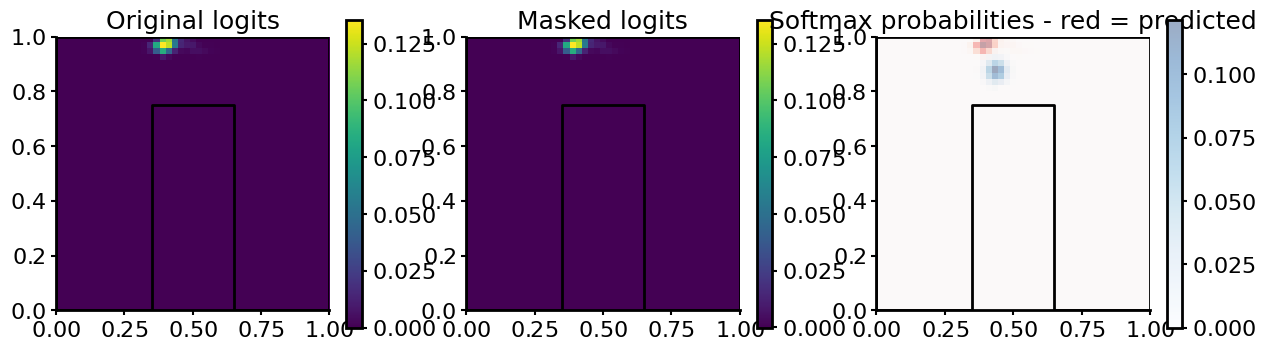

In [15]:
# Assume logits_hw: [B,H,W], target_hw: [B,H,W], heatmap_layer instance exists
from neuroencoders.utils.global_classes import MAZE_COORDS
B, H, W = bayes_logits_hw.shape

# 1️⃣ Mask forbidden logits
allowed_mask = Mouse_Results.bayes.get_allowed_mask(use_tensorflow=False).astype(bool)
masked_logits = np.where(~allowed_mask, -1, bayes_logits_hw)

Mouse_Results.bayes.config.fullBehaviorBandwidth = Mouse_Results.DataHelper.fullBehavior["Bandwidth"]
target_proba = Mouse_Results.ann['108'].GaussianHeatmap.gaussian_heatmap_targets(bayes_truePos)

# 4️⃣ Plot one example
i = np.random.randint(0, B-1)  # first example in batch

plt.figure(figsize=(15,4))

plt.subplot(1,3,1)
plt.title("Original logits")
plt.plot(MAZE_COORDS[:,0], MAZE_COORDS[:,1], 'k-', lw=2)
plt.imshow(bayes_logits_hw[i], origin='lower', extent = (0,1,0,1))
plt.colorbar()

plt.subplot(1,3,2)
plt.title("Masked logits")
plt.plot(MAZE_COORDS[:,0], MAZE_COORDS[:,1], 'k-', lw=2)
plt.imshow(masked_logits[i], origin='lower', vmin=-1e-5, extent= (0,1,0,1))
plt.colorbar()

plt.subplot(1,3,3)
plt.title("Softmax probabilities - red = predicted")
plt.plot(MAZE_COORDS[:,0], MAZE_COORDS[:,1], 'k-', lw=2)

plt.imshow(bayes_logits_hw[i], origin='lower', alpha = 0.6, cmap = "Reds", extent = (0,1,0,1))
plt.imshow(target_proba[i], origin='lower', alpha=0.4, cmap = "Blues", extent = (0,1,0,1))
plt.colorbar()

plt.show()

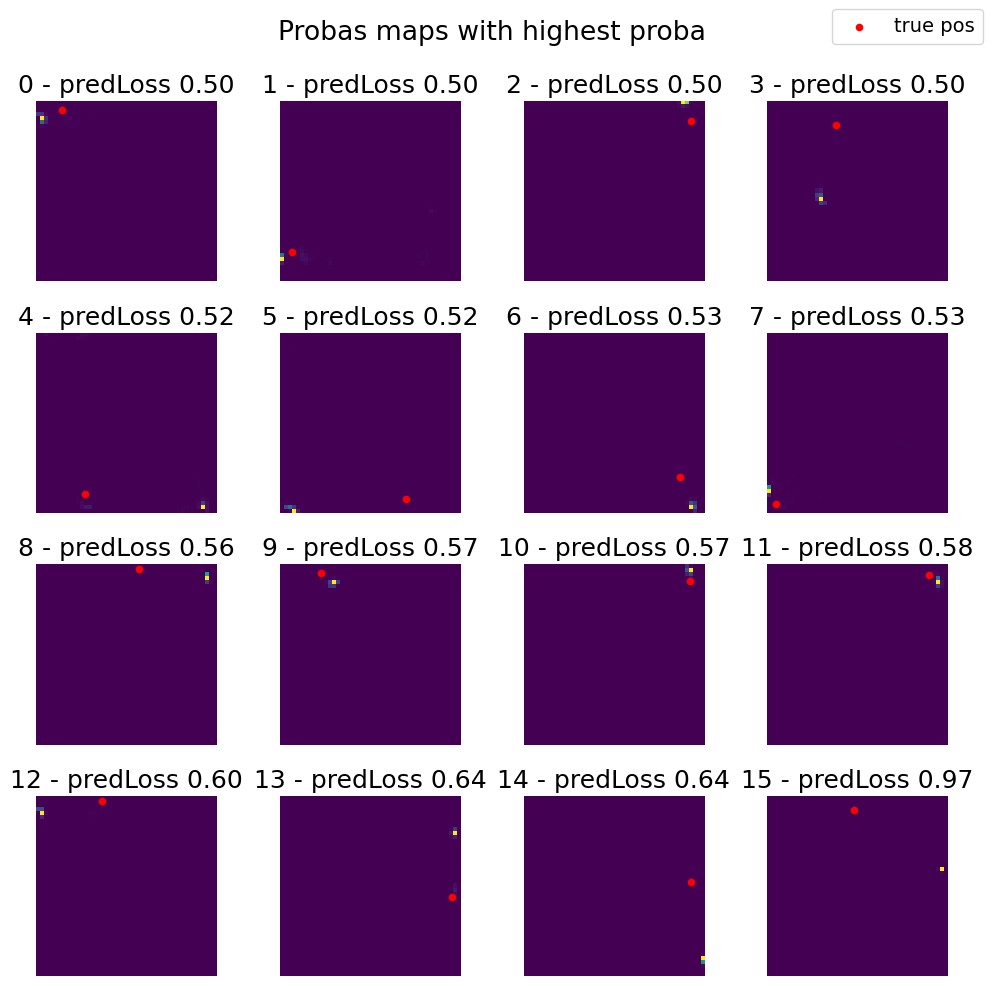

In [16]:
predLoss = bayes_decoding_results["proba"].reshape(-1)

num_subplots = 16
# get 10 smallest predloss
predLoss_sorted_indices = np.argsort(predLoss)[-num_subplots:].flatten()
proba = bayes_decoding_results["probaMaps"]
# plot the first 16 imshow of logits_hw 
fig, axs = plt.subplots(4, 4, figsize=(10, 10))
for i in range(num_subplots):
    ax = axs[i // 4, i % 4]
    ax.imshow(proba[predLoss_sorted_indices[i], :, :], origin='lower', vmin=0, extent = (0,1,0,1), label = "scaled proba")
    ax.scatter(bayes_truePos[predLoss_sorted_indices[i],0], bayes_truePos[predLoss_sorted_indices[i],1], c='r', s=20, label = "true pos")
    ax.set_title(f'{i} - predLoss {predLoss[predLoss_sorted_indices[i]]:.2f}')
    ax.axis('off')
fig.suptitle("Probas maps with highest proba")
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right')

plt.tight_layout()
plt.show()

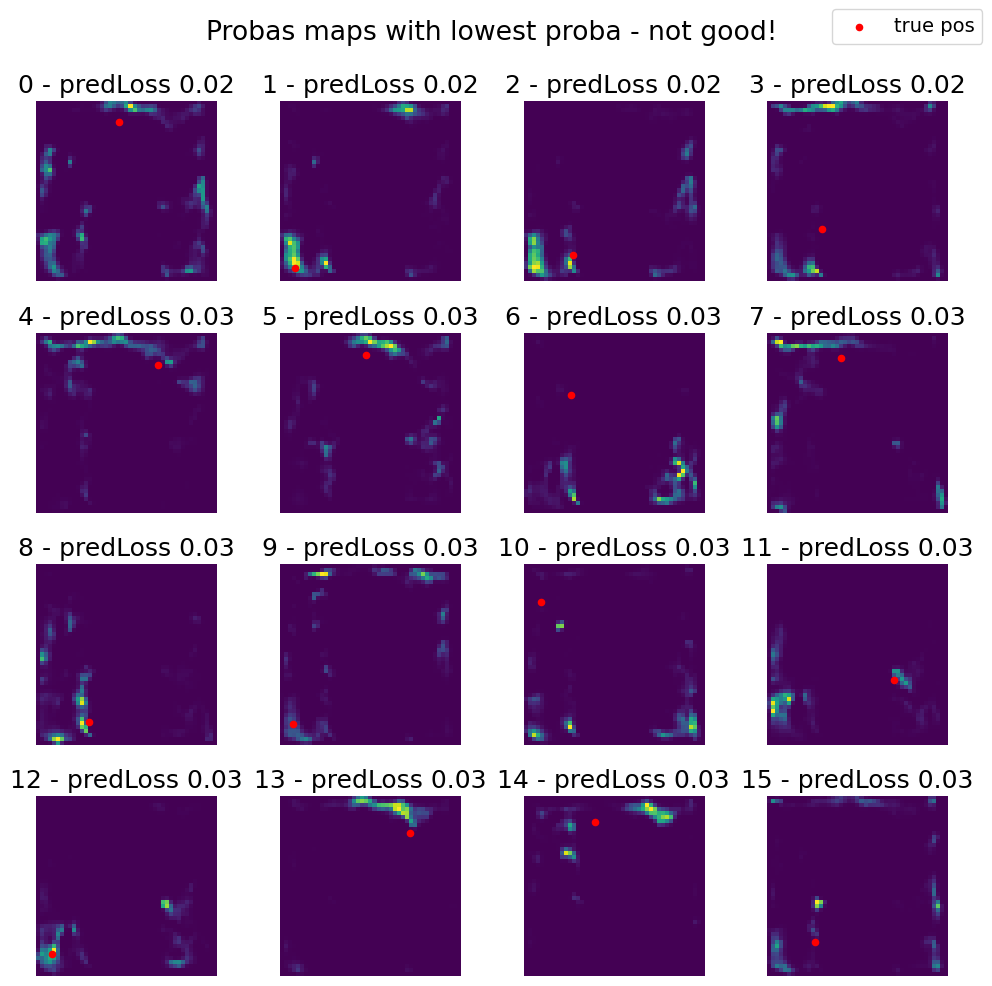

In [17]:
predLoss = bayes_decoding_results["proba"].reshape(-1)

num_subplots = 16
# get 10 smallest predloss
predLoss_sorted_indices = np.argsort(predLoss)[:num_subplots].flatten()
proba = bayes_decoding_results["probaMaps"]
# plot the first 16 imshow of logits_hw 
fig, axs = plt.subplots(4, 4, figsize=(10, 10))
for i in range(num_subplots):
    ax = axs[i // 4, i % 4]
    ax.imshow(proba[predLoss_sorted_indices[i], :, :], origin='lower', vmin=0, extent = (0,1,0,1), label = "scaled proba")
    ax.scatter(bayes_truePos[predLoss_sorted_indices[i],0], bayes_truePos[predLoss_sorted_indices[i],1], c='r', s=20, label = "true pos")
    ax.set_title(f'{i} - predLoss {predLoss[predLoss_sorted_indices[i]]:.2f}')
    ax.axis('off')
fig.suptitle("Probas maps with lowest proba - not good!")
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right')

plt.tight_layout()
plt.show()

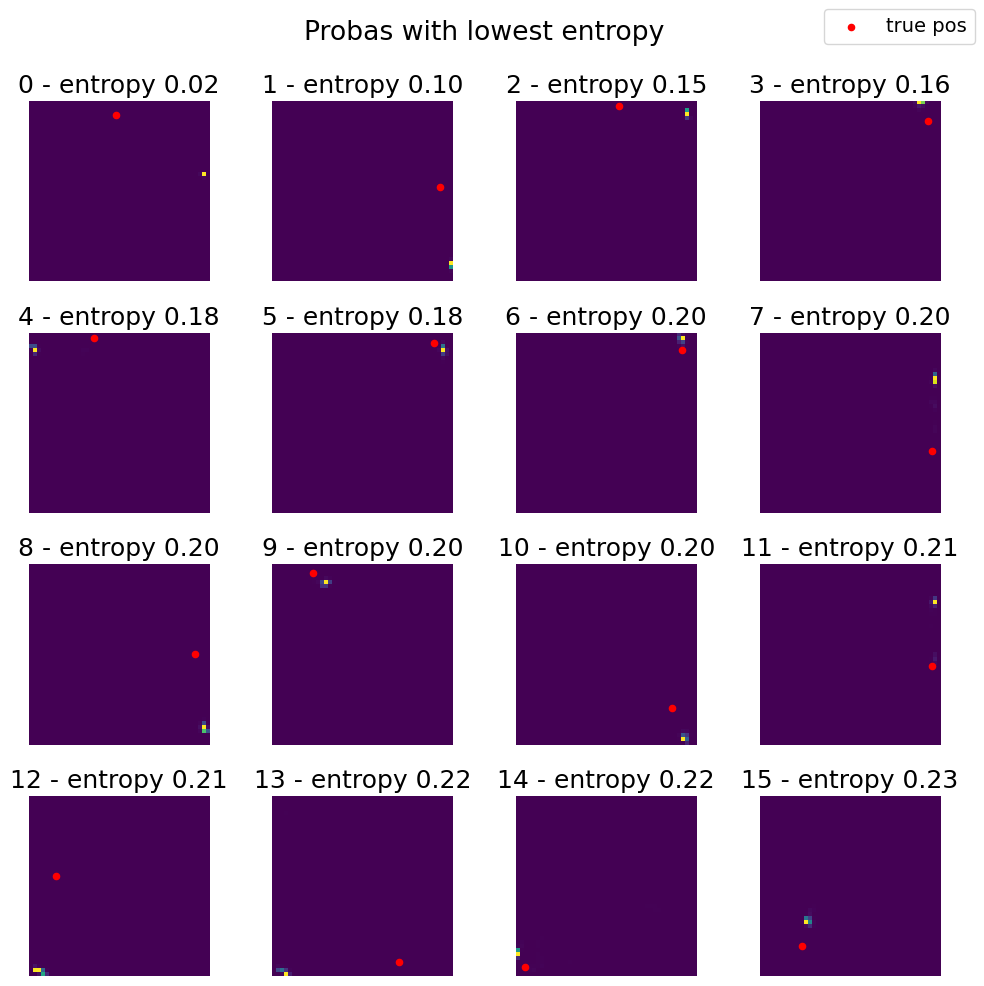

In [18]:
num_subplots = 16
# get 10 smallest entropy
entropy_sorted_indices = np.argsort(bayes_entropy_hw)[:num_subplots] 

proba = bayes_decoding_results["probaMaps"]
# plot the first 16 imshow of logits_hw 
fig, axs = plt.subplots(4, 4, figsize=(10, 10))
for i in range(num_subplots):
    ax = axs[i // 4, i % 4]
    ax.imshow(proba[entropy_sorted_indices[i], :, :], origin='lower', vmin=0, extent = (0,1,0,1), label = "scaled proba")
    ax.scatter(bayes_truePos[entropy_sorted_indices[i],0], bayes_truePos[entropy_sorted_indices[i],1], c='r', s=20, label = "true pos")
    ax.set_title(f'{i} - entropy {bayes_entropy_hw[entropy_sorted_indices[i]]:.2f}')
    ax.axis('off')
fig.suptitle("Probas with lowest entropy")
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right')

plt.tight_layout()
plt.show()

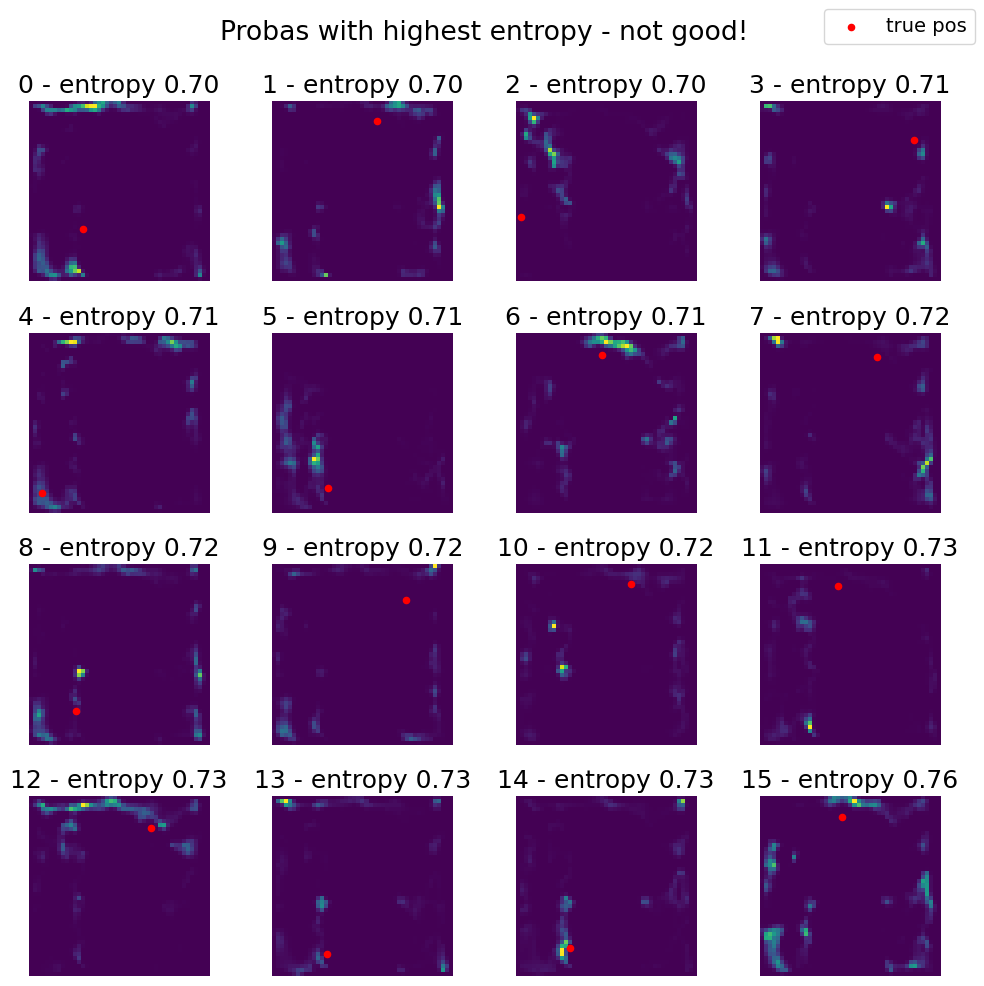

In [19]:
num_subplots = 16
# get 10 smallest entropy
entropy_sorted_indices = np.argsort(bayes_entropy_hw)[-num_subplots:] 

proba = bayes_decoding_results["probaMaps"]
# plot the first 16 imshow of logits_hw 
fig, axs = plt.subplots(4, 4, figsize=(10, 10))
for i in range(num_subplots):
    ax = axs[i // 4, i % 4]
    ax.imshow(proba[entropy_sorted_indices[i], :, :], origin='lower', vmin=0, extent = (0,1,0,1), label = "scaled proba")
    ax.scatter(bayes_truePos[entropy_sorted_indices[i],0], bayes_truePos[entropy_sorted_indices[i],1], c='r', s=20, label = "true pos")
    ax.set_title(f'{i} - entropy {bayes_entropy_hw[entropy_sorted_indices[i]]:.2f}')
    ax.axis('off')
fig.suptitle("Probas with highest entropy - not good!")
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right')

plt.tight_layout()
plt.show()

In [25]:

# Compute KL loss
batch_pos = bayes_decoding_results["featureTrue"]
kl_loss = Mouse_Results.ann['108'].GaussianHeatmap.safe_kl_heatmap_loss(bayes_logits_hw, target_proba)
print("KL loss for bayes:", kl_loss.numpy())

# Check that forbidden bins have zero probability
masked_logits = tf.where(Mouse_Results.ann['108'].GaussianHeatmap.forbid_mask_tf[None]>0, Mouse_Results.ann['108'].GaussianHeatmap.NEG, bayes_logits_hw)
probs = tf.nn.softmax(tf.reshape(masked_logits, [len(batch_pos),45*45]), axis=-1)
probs = tf.reshape(probs, [len(batch_pos),45,45])
probs *= (1.0 - Mouse_Results.ann['108'].GaussianHeatmap.forbid_mask_tf[None])
probs /= tf.reduce_sum(probs, axis=[1,2], keepdims=True)
print("Max probability in forbidden area (should be 0):",
tf.reduce_max(probs * Mouse_Results.ann['108'].GaussianHeatmap.forbid_mask_tf[None]).numpy())

KL loss for bayes: 4.312765
Max probability in forbidden area (should be 0): 0.0


In [34]:
sample_idx = 1
probs = bayes_logits_hw[sample_idx]
print("Max prob:", probs.max())
topk = tf.math.top_k(probs, k=10)
print("Top 10 probs:", topk.values.numpy())


Max prob: 0.06736324601637747
Top 10 probs: [[3.80755287e-04 1.74567737e-04 1.01962851e-04 8.73037266e-06
  4.61508041e-06 3.36635969e-06 3.03583515e-06 2.22255586e-06
  1.06583864e-06 8.82463656e-07]
 [1.00494173e-02 6.07707762e-03 3.00216769e-03 2.10604358e-03
  9.03161818e-04 3.60141400e-04 3.21210626e-04 8.57077473e-05
  4.34330406e-06 3.77104288e-06]
 [2.57120185e-02 1.15960065e-02 7.63923157e-03 4.60053414e-03
  2.79812673e-03 2.64906236e-03 2.60696157e-03 1.23336277e-03
  1.00069281e-03 2.04248449e-04]
 [4.12005879e-02 1.54750734e-02 3.69477515e-03 2.52528133e-03
  2.50942966e-03 1.46437549e-03 7.88600811e-04 3.10551288e-04
  2.63591339e-04 2.34615512e-04]
 [2.05888202e-02 1.53662138e-02 9.63112950e-03 6.50018038e-03
  5.46234927e-03 3.48905997e-03 2.76225302e-03 1.32627396e-03
  1.52658771e-04 4.59042759e-05]
 [3.54071177e-02 1.66708430e-02 1.14979552e-02 1.06646389e-02
  3.97573914e-03 2.78085026e-03 2.67295985e-03 1.50721485e-03
  8.59163793e-04 1.52223955e-04]
 [5.37433855e-

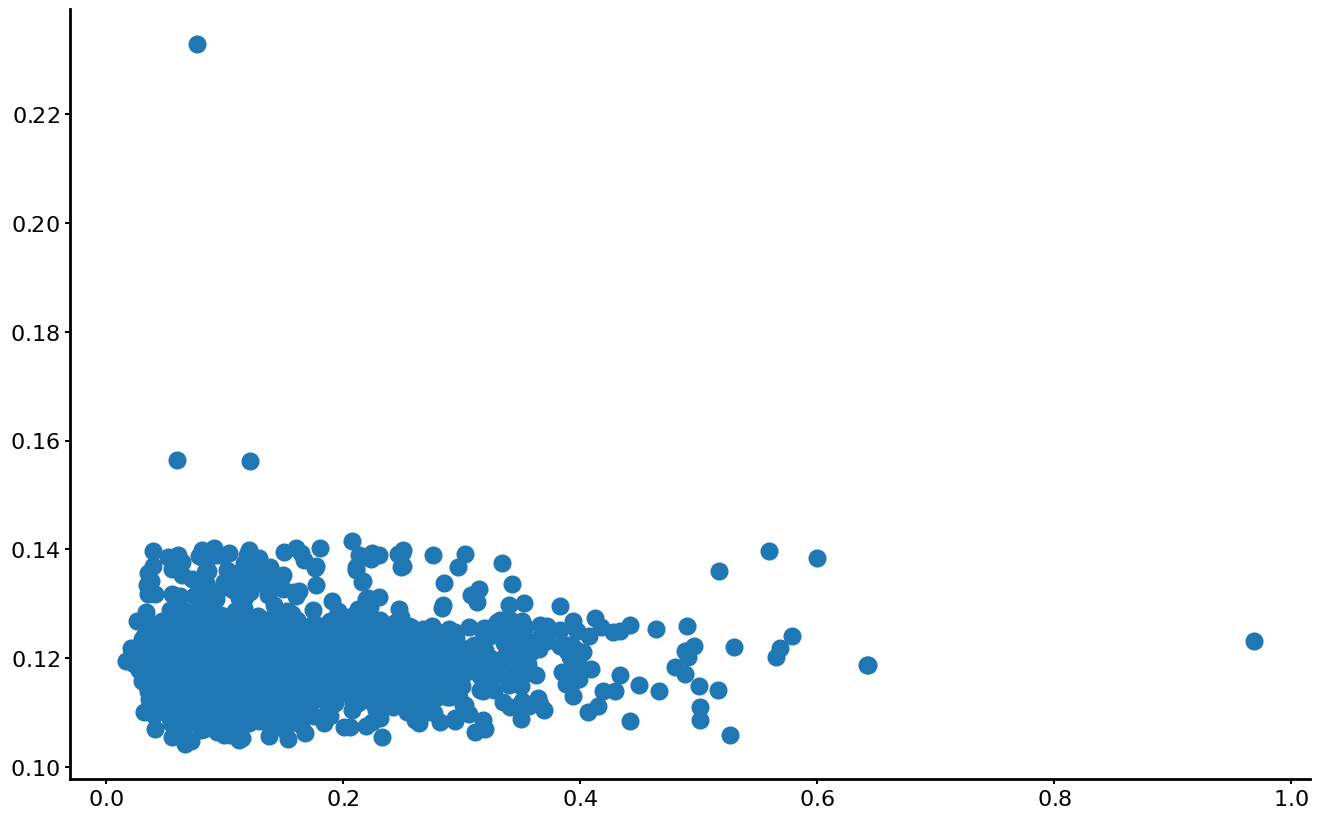

In [88]:
max_proba = bayes_decoding_results["proba"]
target_proba_flat = target_proba.numpy().reshape(B, -1)
true_proba = target_proba_flat.max(axis = -1)
plt.scatter(max_proba.reshape(-1), true_proba.reshape(-1))

KL loss for bayes: 4.312765


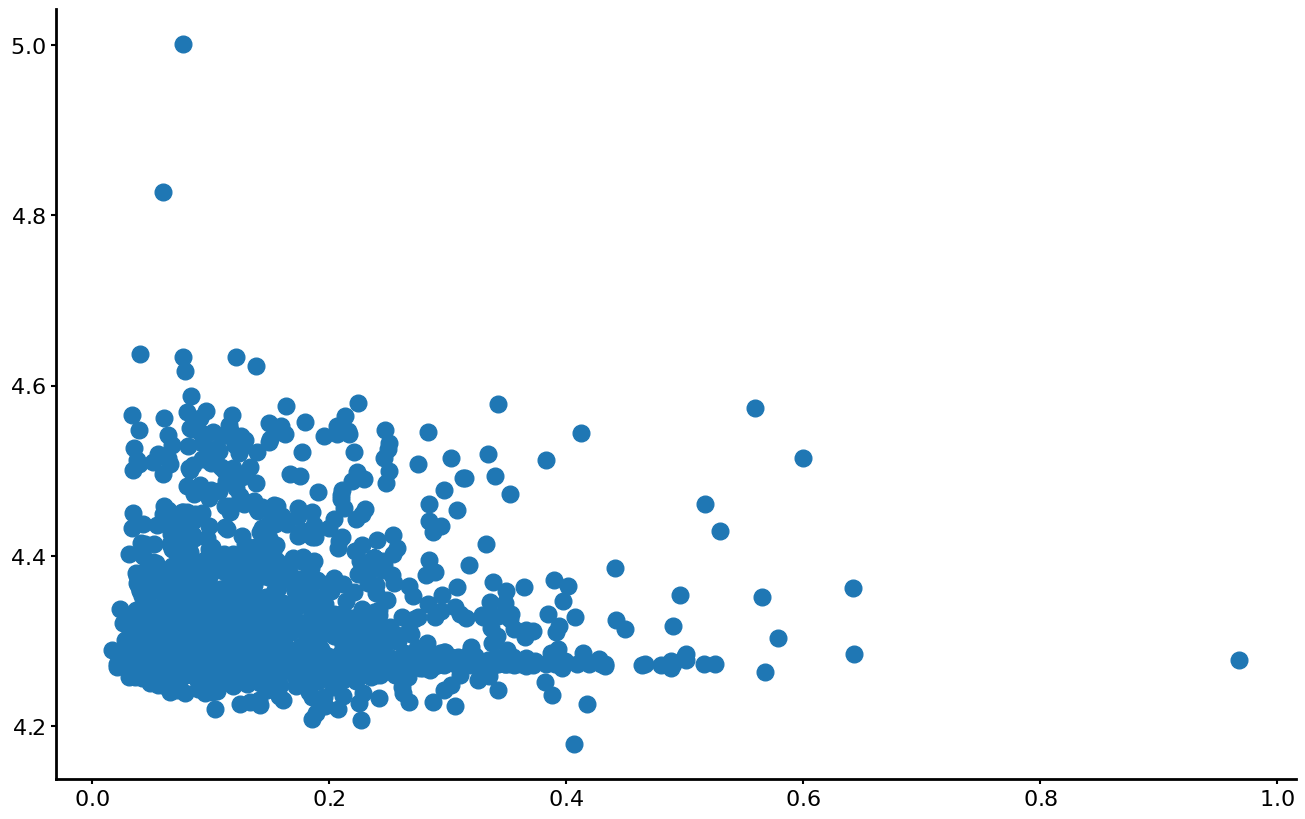

In [119]:
# Compute KL loss
batch_pos = bayes_decoding_results["featureTrue"]
kl_loss = Mouse_Results.ann['108'].GaussianHeatmap.safe_kl_heatmap_loss(bayes_logits_hw, target_proba, return_batch = True)
print("KL loss for bayes:", kl_loss.numpy().mean())
plt.plot(bayes_decoding_results["proba"], kl_loss.numpy(), 'o')

### end of logits stuff

In [8]:
Mouse_Results_Cond = mf.Mouse_Results(Dir, mouse_name=mouse, manipe=manipe, target=target, 
                                                        nameExp=nameExp, nEpochs=nEpochs, phase="cond", 
                                                        deviceName=deviceName, windows=windowSizeMS,
                                                        isTransformer = "LSTM" not in nameExp, denseweight= True, 
                                                        transform_w_log = True,
                                                        which = "both",
                                                        isPredLoss = False,
                                                        bayes_project_path = nameExp_Bayes,
                                                        )

Path for 1199 found: /media/mickey/DataTheotime210/DimaERC2/neuroencoders_1021/_work/M1199_PAG
Windows found for 1199: ['108', '252']
/media/mickey/DataTheotime210/DimaERC2/neuroencoders_1021/_work/M1199_PAG/new_GaussianHeatMap_LinearLoss_Dense_Transformer/results
extending trainEpochs with lossPredSetEpochs as you're not using predLoss
found data_helper, using its custom lines
Linearization points have been created before
/media/mickey/DataTheotime210/DimaERC2/neuroencoders_1021/_work/M1199_PAG/new_GaussianHeatMap_LinearLoss_Dense_Transformer/results


/home/mickey/Documents/Theotime/neuroEncoders/.venv/lib/python3.10/site-packages/tables/attributeset.py:295: DataTypeWarning: Unsupported type for attribute 'MATLAB_fields' in node 'optional'. Offending HDF5 class: 9
  value = self._g_getattr(self._v_node, name)
/home/mickey/Documents/Theotime/neuroEncoders/.venv/lib/python3.10/site-packages/tables/attributeset.py:295: DataTypeWarning: Unsupported type for attribute 'MATLAB_fields' in node 'behavior'. Offending HDF5 class: 9
  value = self._g_getattr(self._v_node, name)


extending trainEpochs with lossPredSetEpochs as you're not using predLoss
found data_helper, using its custom lines
Linearization points have been created before
Setting up GaussianHeatmapLayer...
UMazeProjectionLayer initialized with params: {'x_min': 0.0, 'x_max': 1.0, 'y_min': 0.0, 'y_max': 1.0, 'gap_x_min': 0.35, 'gap_x_max': 0.65, 'gap_y_min': 0.75}
Using Transformer architecture !
loading custom bayes project path from current_LogLoss_Transformer_Dense_Transformer
Reading saved cluster csv file


100%|██████████| 4/4 [00:10<00:00,  2.53s/it]


finished reading
Setting up GaussianHeatmapLayer...
UMazeProjectionLayer initialized with params: {'x_min': 0.0, 'x_max': 1.0, 'y_min': 0.0, 'y_max': 1.0, 'gap_x_min': 0.35, 'gap_x_max': 0.65, 'gap_y_min': 0.75}
Using Transformer architecture !
======================M1199=======================
Mouse_Results for 1199 (PAG)
Experiment: new_GaussianHeatMap_LinearLoss_Dense_Transformer
Target: pos
Phase: cond
Path: /media/mickey/DataTheotime210/DimaERC2/neuroencoders_1021/_work/M1199_PAG
Windows: 108, 252


In [9]:
Mouse_Results.load_data(suffixes = ["_pre", "_cond", "_training"])

In [10]:
from neuroencoders.importData.epochs_management import inEpochs
from functools import reduce

trainMask = reduce(
    np.intersect1d, inEpochs(
    Mouse_Results.data_helper['108'].fullBehavior["positionTime"][:,0],
    Mouse_Results.data_helper['108'].fullBehavior["Times"]["trainEpochs"]
), np.where(Mouse_Results.data_helper['108'].fullBehavior["Times"]["speedFilter"]))


In [11]:
train_pos = Mouse_Results.data_helper['108'].fullBehavior["Positions"][trainMask]
train_pos = train_pos[~np.isnan(train_pos).any(axis=1)]  # remove NaNs

In [12]:
Mouse_Results.bayes.config.fullBehaviorBandwidth = Mouse_Results.data_helper['108'].fullBehavior["Bandwidth"]
Mouse_Results.bayes.config.bandwidth = None

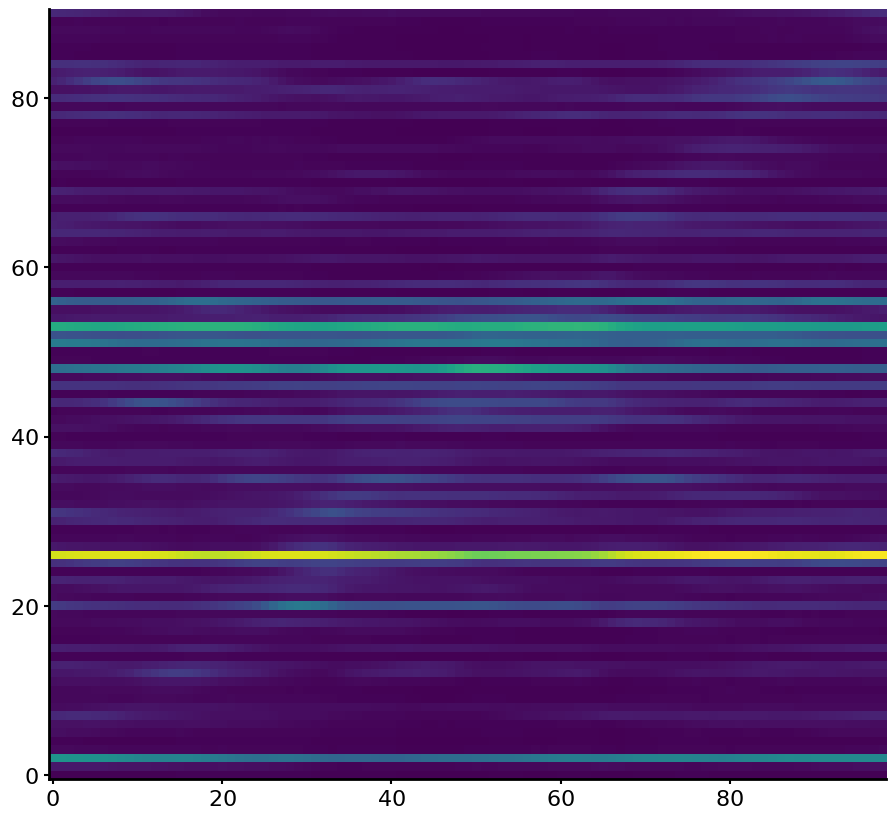

In [68]:
# z-score ordered place fields
ordered_linear_scored = (Mouse_Results.bayes_matrices["orderedLinearPlaceFields"] - Mouse_Results.bayes_matrices["orderedLinearPlaceFields"].mean(axis=0)) / Mouse_Results.bayes_matrices["orderedLinearPlaceFields"].std(axis=0)

plt.imshow(ordered_linear_scored, origin = "lower")

In [101]:
Mouse_Results.load_bayes(suffixes = ["_pre", "_training"])

2025-09-04 13:57:08,559 - INFO - Starting Bayesian decoding with 108ms windows



                        Trouble finding bayesian results in folder, will test now because:
                        
                            Bayesian and NN results do not have the same shape for
                            108 ms window. 
                            Found shapes (22144, 2) and (22016, 2).
                            
                        
Using training data for training phase!


2025-09-04 13:57:08,787 - INFO - Running parallel PyKeOps Bayesian decoding...
2025-09-04 13:57:19,137 - INFO - Finished bayesien guess, will now process and clean.


Saving results in /media/mickey/DataTheotime210/DimaERC2/neuroencoders_1021/_work/M1199_PAG/new_GaussianHeatMap_LinearLoss_Dense_Transformer/results/108.


2025-09-04 13:57:21,206 - INFO - === Decoding Summary ===
2025-09-04 13:57:21,207 - INFO - Window size: 108ms
2025-09-04 13:57:21,207 - INFO - Time steps: 22016
2025-09-04 13:57:21,207 - INFO - Number of NaN predictions skipped: 12
2025-09-04 13:57:21,207 - INFO - Mean error: 0.45 units
2025-09-04 13:57:21,208 - INFO - Median error: 0.44 units
2025-09-04 13:57:21,208 - INFO - RMSE: 0.50 units
2025-09-04 13:57:21,208 - INFO - Mean confidence: 0.332
2025-09-04 13:57:21,209 - INFO - ========================
2025-09-04 13:57:21,229 - INFO - Starting Bayesian decoding with 252ms windows



                        Trouble finding bayesian results in folder, will test now because:
                        
                            Bayesian and NN results do not have the same shape for
                            252 ms window. 
                            Found shapes (22016, 2) and (9856, 2).
                            
                        
Using training data for training phase!


2025-09-04 13:57:21,466 - INFO - Running parallel PyKeOps Bayesian decoding...
2025-09-04 13:57:26,741 - INFO - Finished bayesien guess, will now process and clean.


Saving results in /media/mickey/DataTheotime210/DimaERC2/neuroencoders_1021/_work/M1199_PAG/new_GaussianHeatMap_LinearLoss_Dense_Transformer/results/252.


2025-09-04 13:57:27,848 - INFO - === Decoding Summary ===
2025-09-04 13:57:27,849 - INFO - Window size: 252ms
2025-09-04 13:57:27,849 - INFO - Time steps: 9856
2025-09-04 13:57:27,850 - INFO - Number of NaN predictions skipped: 5
2025-09-04 13:57:27,850 - INFO - Mean error: 0.45 units
2025-09-04 13:57:27,850 - INFO - Median error: 0.45 units
2025-09-04 13:57:27,850 - INFO - RMSE: 0.50 units
2025-09-04 13:57:27,851 - INFO - Mean confidence: 0.637
2025-09-04 13:57:27,851 - INFO - ========================


In [ ]:
Mouse_Results_Cond.load_data(suffixes = ["_cond"])
Mouse_Results_Cond.load_bayes(suffixes = ["_cond"], useTrain = True)

In [ ]:
Mouse_Results.load_bayes(suffixes = ["_pre", "_training", "_cond"])

In [14]:
plt.imshow(Mouse_Results.bayesMatrices["occupation"].T, origin="lower")

In [15]:
np.mean(np.linalg.norm(Mouse_Results.resultsBayes_phase["_cond"]["fullPred"][-1] - Mouse_Results.resultsNN_phase["_cond"]["truePos"][-1], axis=1))

In [16]:
Mouse_Results.resultsNN_phase["_cond"]["speedMask"][1].shape

In [17]:
Mouse_Results.resultsBayes_phase["_cond"].keys()

In [18]:
%matplotlib qt

In [19]:
plt.plot(Mouse_Results.resultsBayes_phase["_training"]["predLoss"][-1].flatten())

In [41]:
Mouse_Results.resultsNN_phase["_cond"]["predLoss"][-1]

In [42]:
Mouse_Results.resultsNN_phase["_training"]["fullPred"][-1].shape

In [43]:
Mouse_Results.resultsBayes_phase["_training"]["fullPred"][-1].shape

In [44]:
Mouse_Results.compare_nn_bayes_with_random_pred(108, phase = "cond")

In [45]:
Mouse_Results.fft_pc(decoding = "ann")

### play with bayesian trainer

In [46]:
Mouse_Results.bayes.orderedLinearPlaceFields.shape

In [47]:
Mouse_Results.bayesMatrices["rateFunctions"][0][1].shape

In [48]:
Mouse_Results.bayesian_neurons_summary()

In [49]:
Mouse_Results.predLoss_euclError(scaled=True)

In [58]:
Mouse_Results.predLoss_vs_trueLoss(typeDec = "bayes")

In [51]:
Mouse_Results.correlate_predLoss_and_bayesProba(phase = "cond")

In [52]:
Mouse_Results.compare_nn_bayes_with_random_pred(252)

In [100]:
Mouse_Results.predLoss_linError(typeDec="ann", phase = "training", speed = "fast", scaled = False)

In [107]:
Mouse_Results.fig_example_linear_filtered(phase = "training")

In [115]:
Mouse_Results.run_spike_alignment()

In [111]:
Mouse_Results.plot_pc_tuning_curve_and_predictions(phase = "pre", ws = 252, block = False, show = False)

In [96]:
Mouse_Results.predLoss_euclError(typeDec="ann", phase = "training", speed = "fast")

### back to all

In [124]:
Mouse_Results.load_data(suffixes = ["_training", "_cond", "_pre"])

In [125]:
Mouse_Results.resultsNN_phase["_pre"]["posIndex"][0]

In [126]:
Mouse_Results.resultsNN_phase["_pre"]["truePos"][0][:,0]

In [127]:
Mouse_Results.data_helper['108'].fullBehavior["Positions"][Mouse_Results.resultsNN_phase["_pre"]["posIndex"][0]][:,0]

In [129]:
Mouse_Results.data_helper['108'].fullBehavior["Speed"][Mouse_Results.resultsNN_phase["_pre"]["posIndex"][0]]

In [130]:
%matplotlib qt

In [131]:
Mouse_Results

In [132]:
Mouse_Results.data_helper['108'].fullBehavior['Times']['start_freeze'][455]

In [133]:
Mouse_Results_Cond = MOBS_Functions.Mouse_Results(Dir, mouse_name=mouse, manipe=manipe, target=target, 
                                                        nameExp=nameExp, nEpochs=nEpochs, phase="cond", 
                                                        deviceName="gpu", windows=windowSizeMS,
                                                        isTransformer = "LSTM" not in nameExp, denseweight= True, 
                                                        transform_w_log = True,
                                                        which = "ann",
                                                        isPredLoss = False,
                                                        )

In [20]:
Mouse_Results_Cond.load_data(suffixes = ["_training", "_cond", "_pre"])

In [21]:
Mouse_Results.windows_values

In [22]:
positionTime_NN = Mouse_Results.resultsNN_phase["_cond"]["time"][1]
position_NN = Mouse_Results.resultsNN_phase["_cond"]["truePos"][1]
posIndex_NN = Mouse_Results.resultsNN_phase["_cond"]["posIndex"][1]

In [23]:
position_NN

In [24]:
positionTime = Mouse_Results.data_helper['252'].fullBehavior['positionTime']
position = Mouse_Results.data_helper['252'].fullBehavior['Positions'][posIndex_NN][:,0]

In [25]:
PosMat = Mouse_Results.data_helper['252'].fullBehavior['Times']['PosMat']
PosMatStimMask = PosMat[:,3] ==1
PosMatStimMask.sum()

In [26]:
stim_indices = np.where(PosMatStimMask)[0]

In [27]:
stim_indices

In [28]:
tRipples = Mouse_Results.data_helper['252'].fullBehavior['Times']['tRipples']

In [29]:
# we have a high prob of having ripples during sleep, so let's crop tRipples to wake epochs by selecting values in train/test epochs (ie wake most of the time, or subsets of wake that we will plot)
ripples_indices = np.array(
                    sorted(
                            [
                                ep.find_closest_index(
                                    positionTime, t, tolerance=True
                                )
                                for t in tRipples
                            ]
                    )
                )
ripples_indices = ripples_indices[ripples_indices != -1]

In [30]:

start_freeze = Mouse_Results.data_helper['108'].fullBehavior['Times']['start_freeze']
stop_freeze = Mouse_Results.data_helper['108'].fullBehavior['Times']['stop_freeze']

### looking at pre

In [78]:
prediction_time = Mouse_Results.resultsNN_phase["_pre"]["time"][1]
predicted = Mouse_Results.resultsNN_phase["_pre"]["fullPred"][1]
positions_from_NN = Mouse_Results.resultsNN_phase["_pre"]["truePos"][1]
posIndex = Mouse_Results.resultsNN_phase["_pre"]["posIndex"][1]
linearized_pred = Mouse_Results.resultsNN_phase["_pre"]["linPred"][1]
linearized_true = Mouse_Results.l_function(Mouse_Results.data_helper['252'].fullBehavior["Positions"])[1]

In [85]:
positions = Mouse_Results.data_helper['252'].fullBehavior["Positions"]

In [79]:
speed_mask = Mouse_Results.resultsNN_phase["_pre"]["speedMask"][1]

In [80]:
time = Mouse_Results.data_helper['252'].fullBehavior["positionTime"]

In [81]:
direction = Mouse_Results.data_helper['252']._get_traveling_direction(linearized_true)

In [82]:
direction = Mouse_Results.data_helper['252']._get_traveling_direction(linearized_true)

In [83]:
epochMask = ep.inEpochsMask(
    time,
    Mouse_Results.data_helper['252'].fullBehavior["Times"]["testEpochs"],
).flatten()

In [84]:
otherMask = (time >= prediction_time[0]) & (time <= prediction_time[-1])
otherMask = otherMask.flatten()

In [182]:
winms = "252"
suffix = "_pre"
idx = 1
phase = "pre"

In [191]:
Mouse_Results.save_video_frame_linearly(
    data_helper=Mouse_Results.data_helper[winms],
    positions=Mouse_Results.resultsNN_phase[suffix]["truePos"][
        idx
    ],
    predicted=Mouse_Results.resultsNN_phase[suffix]["fullPred"][
        idx
    ],
    prediction_time=Mouse_Results.resultsNN_phase[suffix][
        "time"
    ][idx],
    posIndex=Mouse_Results.resultsNN_phase[suffix]["posIndex"][
        idx
    ],
    linearized_true=linearized_true,
    linearized_pred=Mouse_Results.resultsNN_phase[suffix][
        "linPred"
    ][idx],
    windowSizeMS=252,
    pair_points=True,
    l_function=Mouse_Results.l_function,
    linear_position_mode=True,
    alpha_delta_line=0.75,
    blit=False,
    plot_all_stims=(phase == "cond"),
    auto_encode=True,
    dpi=300,
    output_dir=os.path.join(
        "/home/mickey/download",
        "tmp_figures",
        "filtered",
    ),
    video_path=os.path.join(
        "/home/mickey/download",
        "tmp_figures",
        "filtered_video_better.mp4",
    ))

In [198]:
Mouse_Results.show_movie(phase = "pre", linear_position_mode = True, l_function = Mouse_Results.l_function,
                         prediction_time = prediction_time, predicted = predicted,
                         positions_from_NN = positions_from_NN, posIndex = posIndex, 
                         linearized_true = linearized_true, linearized_pred = linearized_pred, 
                         very_simple_plot = False, plot_all_stims = False, fps = 256, blit = False,
                         interval = 50)

### Looking at cond

In [66]:
Mouse_Results.resultsNN_phase["_cond"].keys()

In [32]:
prediction_time = Mouse_Results.resultsNN_phase["_cond"]["time"][1][:500]
predicted = Mouse_Results.resultsNN_phase["_cond"]["fullPred"][1][:500]
positions_from_NN = Mouse_Results.resultsNN_phase["_cond"]["truePos"][1][:500]
posIndex = Mouse_Results.resultsNN_phase["_cond"]["posIndex"][1][:500]
linearized_pred = Mouse_Results.resultsNN_phase["_cond"]["linPred"][1][:500]
linearized_true = Mouse_Results.l_function(Mouse_Results.data_helper['252'].fullBehavior["Positions"])[1]

In [33]:
speed_mask = Mouse_Results.resultsNN_phase["_cond"]["speedMask"][1][:500]

In [34]:
# create a random boolean mask for predLoss, size 200
predLoss_mask = np.random.choice([True, False], size=200, p=[0.7, 0.3])

In [35]:
time = Mouse_Results.data_helper['252'].fullBehavior["positionTime"]

In [61]:
direction = Mouse_Results.data_helper['252']._get_traveling_direction(linearized_true)

In [36]:
epochMask = ep.inEpochsMask(
    time,
    Mouse_Results.data_helper['252'].fullBehavior["Times"]["testEpochs"],
)

In [37]:
direction = Mouse_Results.data_helper['252']._get_traveling_direction(linearized_true)

In [38]:
epochMask = epochMask.flatten()

In [63]:
otherMask = (time >= prediction_time[0]) & (time <= prediction_time[-1])
otherMask = otherMask.flatten()

In [39]:
plt.scatter(time[epochMask], linearized_true[epochMask], c = direction[epochMask])
plt.colorbar()

In [40]:
otherMask = (time >= prediction_time[0]) & (time <= prediction_time[-1])
otherMask = otherMask.flatten()

In [50]:
direction_pred = Mouse_Results.data_helper['252']._get_traveling_direction(Mouse_Results.resultsNN_phase["_cond"]["linTruePos"][1][:500])

In [49]:
plt.scatter(positions_from_NN[:,0], positions_from_NN[:,1], c = direction_pred)
plt.colorbar()

In [44]:
plt.scatter(time[otherMask], linearized_true[otherMask], c = direction[otherMask])
plt.colorbar()

In [45]:
direction_pred = Mouse_Results.data_helper['252']._get_traveling_direction(linearized_pred)

In [46]:
plt.scatter(prediction_time, linearized_pred, c = direction_pred)

In [54]:
Mouse_Results.show_movie(phase = "cond", linear_position_mode = True, l_function = Mouse_Results.l_function,
                         prediction_time = prediction_time, predicted = predicted,
                         positions_from_NN = positions_from_NN, posIndex = posIndex, 
                         linearized_true = linearized_true, linearized_pred = linearized_pred, very_simple_plot = False, plot_all_stims = True)

### just looking

In [14]:
%matplotlib qt

In [22]:
quantile_predLoss = np.quantile(
    Mouse_Results.resultsNN_phase["_pre"]["predLoss"][-1], 0.3
)
selection = (
    Mouse_Results.resultsNN_phase["_pre"]["predLoss"][-1]
    < quantile_predLoss
)

In [74]:
Mouse_Results.DataHelper.fullBehavior

In [102]:
Mouse_Results.DataHelper.get_training_imbalance()

In [96]:
Mouse_Results.shock_zone
x_min, x_max = Mouse_Results.shock_zone[:, 0].min(), Mouse_Results.shock_zone[:, 0].max()
y_min, y_max = Mouse_Results.shock_zone[:, 1].min(), Mouse_Results.shock_zone[:, 1].max()

training_mask = ep.inEpochsMask(
    Mouse_Results.DataHelper.fullBehavior['positionTime'],
    Mouse_Results.DataHelper.fullBehavior['Times']['trainEpochs'],
).flatten() & np.logical_not(np.isnan(Mouse_Results.DataHelper.fullBehavior['Positions']).any(axis=1))

in_shock_zone_mask = (
    (Mouse_Results.DataHelper.fullBehavior['Positions'][training_mask, 0] >= x_min) &
    (Mouse_Results.DataHelper.fullBehavior['Positions'][training_mask, 0] <= x_max) &
    (Mouse_Results.DataHelper.fullBehavior['Positions'][training_mask, 1] >= y_min) &
    (Mouse_Results.DataHelper.fullBehavior['Positions'][training_mask, 1] <= y_max)
)

In [99]:
plt.hist2d(Mouse_Results.DataHelper.fullBehavior['Positions'][training_mask, 0], Mouse_Results.DataHelper.fullBehavior['Positions'][training_mask, 1], bins=100)

In [101]:
(Mouse_Results.DataHelper.fullBehavior['Positions'][training_mask, 0] <= x_max).sum() / (Mouse_Results.DataHelper.fullBehavior['Positions'][training_mask, 0] >= 0.655555).sum()

In [71]:
plt.scatter(Mouse_Results.resultsNN_phase["_pre"]["truePos"][-1][:, 0], Mouse_Results.resultsNN_phase["_pre"]["truePos"][-1][:, 1], c = in_shock_zone_mask, s=10)

In [ ]:
np.where(Mouse_Results.DataHelper.fullBehavior['Positions'])

In [48]:
Mouse_Results.DataHelper.fullBehavior['Positions']

In [115]:
Mouse_Results.Params.isTransformer

In [112]:
Mouse_Results.show_movie(
    positions = Mouse_Results.resultsNN['truePos'][-1],
    predicted= Mouse_Results.resultsNN['fullPred'][-1],
    speedMaskArray = Mouse_Results.resultsNN['speedMask'][-1],
    #predLossMask = selection,
    pair_points = True, interval = 70, l_function = Mouse_Results.l_function, linear_position_mode = True,
    alpha_delta_line= 0.75, blit = True, window_size=2
)

In [34]:
import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    Mouse_Results.save_video_frame_with_pool(
        output_dir = "/home/mickey/download/bonjourkaotismus",
        video_path = "/home/mickey/Documents/Theotime/neuroEncoders/notebooks/Mouse_Results_1199_PAG_position_WeirdLoss_RMS_newUncertainty_DENSE_LSTM_pre.mp4",
        positions = Mouse_Results.resultsNN['truePos'][-1],
        predicted= Mouse_Results.resultsNN['fullPred'][-1],
        speedMaskArray = Mouse_Results.resultsNN['speedMask'][-1],
        predLossMask = selection,
        pair_points = True, interval = 70, l_function = Mouse_Results.l_function, linear_position_mode = True,
        alpha_delta_line= 0.75, blit = True,
        auto_encode=True
    )

In [16]:
Mouse_Results.show_movie(interval = 60, pair_points = True, fourD_analysis_mode = False, l_function = Mouse_Results.l_function, linear_position_mode = False, be_fast = False, block = True, with_ref_bg = True)

In [126]:
Mouse_Results.show_movie(interval = 60, pair_points = True, fourD_analysis_mode = False, l_function = Mouse_Results.l_function, linear_position_mode = True, save_path = "/home/mickey/Dropbox/karim_laderniere.mp4")

In [11]:
Mouse_Results.load_results(which = "ann", winMS = 108, phase = 'training', useTrain = True, template = 'pre', useSpeedMask = True)

In [12]:
rawdata_parser.speed_filter(
    Mouse_Results.Project.folder,
    overWrite=False,
    phase="cond",
    template="pre",
    window_range=2000,
    force= False,
)
rawdata_parser.select_epochs(
    Mouse_Results.Project.folder,
    overWrite=False,
    phase="cond",
    force=False,
    find_best_sets=True,
)
DataHelper_cond = DataHelperClass(
    Mouse_Results.Project.xml,
    mode="ann",
    target="pos",
    phase="cond",
    nameExp=Mouse_Results.nameExp,
    windowSizeMS=108,
    force_ref=False,
    isPredLoss=False,
)


In [ ]:
helper = DataHelper_cond

In [ ]:
Linearizer = UMazeLinearizer(
    Mouse_Results.Project.folder, phase=helper.phase, data_helper=helper
)
Linearizer.verify_linearization(
    helper.positions / helper.maxPos(),
    Mouse_Results.Project.folder,
    overwrite=False,
)

speedMask = helper.fullBehavior["Times"]["speedFilter"]
epochMask = importData.epochs_management.inEpochsMask(
    helper.fullBehavior["positionTime"][:, 0],
    helper.fullBehavior["Times"]["trainEpochs"],
)
totMask = speedMask * epochMask
full_training_true_positions = helper.fullBehavior["Positions"][totMask]

Linearizer.plot_linearization_variable(
    full_training_true_positions / np.max(full_training_true_positions),
    folder=Mouse_Results.Project.folder,
    show=True,
    training=True,
)

l_function = Linearizer.pykeops_linearization

# Now that we have the linearization function, we can get the true target
helper.get_true_target(
    l_function, in_place=True, show=True, speedMask=True
)


In [15]:
Parameters = Params(
    helper=helper,
    windowSize=0.108,
    nEpochs=200,
    phase="pre",
    batchSize=256,
    save_json=True,
    isTransformer=True,
    transform_w_log=True,
    denseweight=True,
)


In [16]:
Mouse_Results.ann['108'].test(
    helper.fullBehavior,
    l_function = Mouse_Results.l_function,
    windowSizeMS = 108,
    isPredLoss = False,
    useSpeedFilter = False,
    phase = "cond",
    useTrain = True
)

In [17]:
print_results.print_results(
    Mouse_Results.ann['108'].folderResult,
    windowSizeMS=108,
    show=False,
    lossSelection=0.1,
    euclidean=False,
    target="pos",
    phase="cond",
    useSpeedMask=False,
    training_data=Mouse_Results.ann['108'].training_data,
    l_function=Mouse_Results.l_function,
)


In [ ]:
Mouse_Results.load_data()

In [ ]:
Mouse_Results.show_results(save = True, winMS=108, phase = 'pre', useSpeedMask = False)

In [ ]:
Mouse_Results.folderResult

In [ ]:
import dill as pickle

with open("/home/mickey/Documents/Theotime/DimaERC2/neuroencoders_1021/_work/M1199_PAG/PositionSpecificLossWithPL/results/bayesMatrices.pkl", "rb") as f:
    bayesMatrices = pickle.load(f)

In [ ]:
newbayesmat = Mouse_Results.bayes.train_order_by_pos(behaviorData = Mouse_Results.data_helper['252'].fullBehavior, windowSizeMS=252, useTrain=True, l_function = Mouse_Results.l_function)

In [ ]:
results = Mouse_Results.bayes.test_legacy(newbayesmat, behaviorData = Mouse_Results.data_helper['252'].fullBehavior, windowSizeMS=252, useTrain=True)

In [ ]:
results['proba'].max()

In [ ]:
Mouse_Results.old_bayes_matrices = Mouse_Results.bayes_matrices

In [ ]:
Mouse_Results.bayes_matrices = newbayesmat

In [ ]:
print_results.print_results(dir = Mouse_Results.folderResult, show = True, save = False, results = results, typeDec = 'bayes', phase = "pre", target = "pos", windowSizeMS = 252, l_function = Mouse_Results.l_function)

In [ ]:
Mouse_Results.Project.folder

In [ ]:
np.hstack(
    [
        Mouse_Results.DataHelper.fullBehavior['Times']['trainEpochs'],
        Mouse_Results.DataHelper.fullBehavior['Times']['lossPredSetEpochs']
    ]
)

In [ ]:
Mouse_Results.DataHelper.fullBehavior['Times']['lossPredSetEpochs']

In [ ]:
Mouse_Results.DataHelper.fullBehavior['Times']['trainEpochs']

In [ ]:
rawdata_parser.speed_filter(
    Mouse_Results.Project.folder,
    overWrite=True,
    phase="pre",
    window_range=2000,
    force=False
)


In [ ]:
Mouse_Results.DataHelper.fullBehavior.keys()

In [ ]:
plt.hist(Mouse_Results.data_helper['252'].fullBehavior['Speed'][Mouse_Results.data_helper['252'].fullBehavior['Times']['speedFilter'][1:]], bins=100)

In [ ]:
Mouse_Results.load_results(force = True, redo = True, phase = "pre", which = "bayes", winMS = 252)

In [ ]:
Mouse_Results.load_data(suffixes= "_pre")
pre_phase  = Mouse_Results.resultsNN.copy()
Mouse_Results.load_data(suffixes = "_training")
training_phase = Mouse_Results.resultsNN.copy()

In [ ]:
%matplotlib inline

In [ ]:
training_phase['linTruePos']

In [ ]:
winms = 1
plt.scatter(training_phase['linPred'][winms], training_phase['linTruePos'][winms], s = 6, cmap = 'viridis', label = 'Training Phase')
plt.scatter(pre_phase['linPred'][winms], pre_phase['linTruePos'][winms], s = 6, cmap = 'viridis', label = 'Pre Phase')
plt.xlabel('Predicted Position')
plt.ylabel('True Position')
plt.title('Predicted vs True Position')
plt.legend()

In [ ]:
winms = 0
plt.scatter(training_phase['linPred'][winms], training_phase['linTruePos'][winms], s = 6, cmap = 'viridis', label = 'Training Phase')
plt.scatter(pre_phase['linPred'][winms], pre_phase['linTruePos'][winms], s = 6, cmap = 'viridis', label = 'Pre Phase')
plt.xlabel('Predicted Position')
plt.ylabel('True Position')
plt.title('Predicted vs True Position')
plt.legend()

In [ ]:
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(20, 8))
axes = axes.flatten()
H, xedges, yedges = np.histogram2d(pre_phase['linPred'][winms], pre_phase['linTruePos'][winms], bins=(nbins, nbins),density=True )
# H_normalized = H/float(az1.shape[0]) # the integral over the histogrm is 1
H_normalized = H/H.max(axis = 1) # the max value of the histogrm is 1
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

im = axes[0].imshow(H_normalized, extent=extent, cmap='magma', interpolation='none',origin ='lower')
fig.colorbar(im, ax=axes[0])

H, xedges, yedges = np.histogram2d(pre_phase['linPred'][winms][pre_phase['speedMask'][winms]], pre_phase['linTruePos'][winms][pre_phase['speedMask'][winms]], bins=(nbins, nbins),density=True )
# H_normalized = H/float(az1.shape[0]) # the integral over the histogrm is 1
H_normalized = H/H.max(axis = 1) # the max value of the histogrm is 1
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

im = axes[1].imshow(H_normalized, extent=extent, cmap='magma', interpolation='none',origin ='lower')
fig.colorbar(im, ax=axes[1])

H, xedges, yedges = np.histogram2d(training_phase['linPred'][winms], training_phase['linTruePos'][winms], bins=(nbins, nbins),density=True )
# H_normalized = H/float(az1.shape[0]) # the integral over the histogrm is 1
H_normalized = H/H.max(axis = 1) # the max value of the histogrm is 1
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

im = axes[2].imshow(H_normalized, extent=extent, cmap='magma', interpolation='none',origin ='lower')
fig.colorbar(im, ax=axes[2])

H, xedges, yedges = np.histogram2d(training_phase['linPred'][winms][training_phase['speedMask'][winms]], training_phase['linTruePos'][winms][training_phase['speedMask'][winms]], bins=(nbins, nbins),density=True )
# H_normalized = H/float(az1.shape[0]) # the integral over the histogrm is 1
H_normalized = H/H.max(axis = 1) # the max value of the histogrm is 1
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

im = axes[3].imshow(H_normalized, extent=extent, cmap='magma', interpolation='none',origin ='lower')
fig.colorbar(im, ax=axes[3])

plt.show()

In [ ]:
plt.hist2d(training_phase['linPred'][winms], training_phase['linTruePos'][winms], cmap = 'viridis', label = 'Training Phase')


In [ ]:
training_phase.keys()

In [ ]:
pre_phase

In [ ]:
Mouse_Results.load_data(suffix = "_training")

In [ ]:
Mouse_Results.show_results(show = True, phase = "training", save = False)

In [ ]:
Mouse_Results.resultsNN

In [ ]:
Mouse_Results.data_helper['108'].phase

In [ ]:
%matplotlib qt

In [ ]:
Mouse_Results.load_data()

In [ ]:
Mouse_Results.resultsNN.keys()

In [ ]:
x = np.arange(0, 2000)

In [ ]:
%matplotlib inline

In [ ]:
plt.plot(x, - np.exp(-1/40 * x))
plt.plot(x, - np.exp(-1/10 * x))
plt.plot(x, - np.exp(-1/80 * x))
plt.plot(x, - np.exp(-1/100 * x))

In [ ]:
plt.hist2d(inferring[:,0], inferring[:,1], cmap = 'viridis',)

In [ ]:
Mouse_Results.resultsNN['fullPred']

In [ ]:
inferring = Mouse_Results.resultsNN['fullPred'][1]
linferring = Mouse_Results.resultsNN['linPred'][1]
pos = Mouse_Results.resultsNN['truePos'][1]
lpos = Mouse_Results.resultsNN['linTruePos'][1]

error = np.array(
        [np.linalg.norm(inferring[i, :] - pos[i, :]) for i in range(inferring.shape[0])]
    )  # eucledian distance


In [ ]:
error_mask = error > 0.6

In [ ]:
np.max(pos, axis = 0)

In [ ]:
plt.scatter(lpos, linferring)

In [ ]:
plt.hist2d(lpos, linferring, cmap = 'viridis', 
           bins = [np.linspace(0, 1, 20), np.linspace(0, 1, 20)])

In [ ]:
plt.plot(linferring)
plt.plot(lpos)

In [ ]:
plt.hist2d(inferring[error_mask, 0], inferring[error_mask, 1], cmap = 'viridis')
plt.colorbar()

In [ ]:
np.where(np.linalg.norm([Mouse_Results.resultsNN['fullPred'][0], Mouse_Results.resultsNN['truePos'][0]]) > 0)[0]

In [ ]:
Mouse_Results.resultsNN.keys()

In [ ]:
Mouse_Results.show_results(phase = "training", save = True)

In [ ]:
import importData.gui_elements

In [ ]:
%matplotlib qt

In [ ]:
Mouse_Results.resultsNN

In [ ]:
nbins = 30
_, edges = np.histogram(Mouse_Results.resultsNN['linTruePos'][winms])

In [ ]:
winms

In [ ]:
Mouse_Results.load_data(suffix = "_cond")

In [ ]:
plt.hist(Mouse_Results.resultsNN['predLoss'][winms], density = True, bins = 40)

In [ ]:
selection = Mouse_Results.resultsNN['predLoss'][winms] < -5.5

In [ ]:
plotter = importData.gui_elements.AnimatedPositionPlotter(Mouse_Results.data_helper['108'], positions = Mouse_Results.resultsNN['truePos'][winms], 
                                  predicted = Mouse_Results.resultsNN['fullPred'][winms], 
                                  predLossMask = selection,
                                  # speedMaskArray = Mouse_Results.resultsNN['speedMask'][0], 
                                  windowSizeMS = 108, fps = 30, target = target, mouse_name = mouse, manipe = manipe, nameExp = nameExp)

anim = plotter.show(interval=10, repeat=True, block=True, with_ref_bg = False)

In [ ]:
Mouse_Results.data_helper['108']

In [ ]:
Mouse_Results.ann['108'].fix_linearizer(
    Mouse_Results.Linearizer.mazePoints,
    Mouse_Results.Linearizer.tsProj
)

In [ ]:
Mouse_Results.ann['108'].setup_dynamic_dense_loss(
    Mouse_Results.data_helper['108'].fullBehavior, alpha = 1
)

In [ ]:
%matplotlib qt

In [ ]:
print_results.print_results(
    Mouse_Results.ann['108'].folderResult,
    windowSizeMS=108,
    show = True,
    lossSelection = 0.1,
    euclidean = False,
    target = "pos",
    phase = None,
    training_data = Mouse_Results.ann['108'].training_data,
    save = False,
    l_function = Mouse_Results.l_function,
)

In [ ]:
%matplotlib qt

In [ ]:
Mouse_Results

In [ ]:
%matplotlib inline

In [ ]:
%matplotlib qt

In [ ]:
trainMask = importData.epochs_management.inEpochsMask(Mouse_Results.data_helper['108'].fullBehavior["positionTime"][:, 0], Mouse_Results.data_helper['108'].fullBehavior['Times']['trainEpochs']) 
testMask = importData.epochs_management.inEpochsMask(Mouse_Results.data_helper['108'].fullBehavior["positionTime"][:, 0], Mouse_Results.data_helper['108'].fullBehavior['Times']['testEpochs'])
speedMask = Mouse_Results.data_helper['108'].fullBehavior["Times"]['speedFilter']

mask = (trainMask | testMask) * speedMask

In [ ]:
plt.plot(Mouse_Results.data_helper['108'].fullBehavior['positionTime'][:, 0], Mouse_Results.data_helper['108'].fullBehavior['Positions'][:, 0], 'o', markersize=1, alpha=0.5, c= 'r')
plt.plot(Mouse_Results.data_helper['108'].fullBehavior['positionTime'][trainMask, 0], Mouse_Results.data_helper['108'].fullBehavior['Positions'][trainMask, 0], 'o', markersize=1, alpha=1)
plt.plot(Mouse_Results.data_helper['108'].fullBehavior['positionTime'][trainMask, 0], Mouse_Results.data_helper['108'].fullBehavior['Positions'][trainMask, 1], 'o', markersize=1, alpha=1)

In [ ]:
training_data = Mouse_Results.data_helper['108'].fullBehavior['Positions'][mask]
training_data.shape

In [ ]:
plt.plot(Mouse_Results.data_helper['108'].fullBehavior['positionTime'][:, 0], Mouse_Results.data_helper['108'].fullBehavior['Positions'][:, 0], 'o', markersize=1, alpha=0.3, c= 'r')
plt.plot(Mouse_Results.data_helper['108'].fullBehavior['positionTime'][mask, 0], Mouse_Results.data_helper['108'].fullBehavior['Positions'][mask, 0], 'o', markersize=1, alpha=1)
plt.plot(Mouse_Results.data_helper['108'].fullBehavior['positionTime'][mask, 0], Mouse_Results.data_helper['108'].fullBehavior['Positions'][mask, 1], 'o', markersize=1, alpha=1)

In [ ]:
Mouse_Results.show_results(save = False, winMS = 108, phase = 'training', training_data = training_data, lossSelection = 0.1, l_function = Mouse_Results.l_function)

In [ ]:
Mouse_Results.load_data(suffix = "_pre")

In [ ]:
Mouse_Results.resultsNN

In [ ]:
Mouse_Results.test_bayes()

In [ ]:
Mouse_Results.fig_example_XY(108)

In [ ]:
Mouse_Results.fig_example_linear_filtered(fprop = 0.1)

In [ ]:
Mouse_Results.compare_nn_bayes(108, isShow=True)

In [ ]:
Mouse_Results.mean_euclerrors()

In [ ]:
Mouse_Results.predLoss_vs_trueLoss()

In [ ]:
Mouse_Results.nnVSbayes()

In [ ]:
Mouse_Results.mean_linerrors()

In [ ]:
Mouse_Results.predLoss_linError(speed = 'slow', step = 1e-6)

In [ ]:
Mouse_Results.predLoss_euclError(step = 1e-6, scaled = False)

In [ ]:
Mouse_Results.fig_example_2d(speed = 'fast')

In [ ]:
Mouse_Results.hist_linerrors(speed = 'fast')

In [ ]:
Mouse_Results.Params.phase

In [ ]:
Mouse_Results.run_spike_alignment(useTrain = False)

In [ ]:
Mouse_Results.plot_pc_tuning_curve_and_predictions(ws = 108)

In [ ]:
%matplotlib qt

In [ ]:
Mouse_Results.DataHelper.fullBehavior["positionTime"]

In [ ]:
Mouse_Results.load_results(force = True, phase = 'pre')

In [ ]:
from importData.epochs_management import inEpochs


fig, ax = plt.subplots()

ax1 = plt.subplot2grid((2, 1), (0, 0), rowspan=1, colspan=1)
ax2 = plt.subplot2grid((2, 1), (1, 0), rowspan=1, colspan=1)

trainMask = inEpochs(Mouse_Results.data_helper["108"].fullBehavior['positionTime'], Mouse_Results.data_helper["108"].fullBehavior['Times']['trainEpochs'])[0]
testMask = inEpochs(Mouse_Results.data_helper["108"].fullBehavior['positionTime'], Mouse_Results.data_helper["108"].fullBehavior['Times']['testEpochs'])[0]

ax1.plot(Mouse_Results.data_helper["108"].fullBehavior['positionTime'][trainMask], Mouse_Results.data_helper["108"].fullBehavior['Positions'][trainMask, 0],'--.', color='black', label='training',markersize = 6)
ax1.plot(Mouse_Results.data_helper["108"].fullBehavior['positionTime'][testMask], Mouse_Results.data_helper["108"].fullBehavior['Positions'][testMask, 0],'--.', color='red', label='testing',markersize = 6)

ax2.plot(Mouse_Results.data_helper["108"].fullBehavior['positionTime'][trainMask], Mouse_Results.data_helper["108"].fullBehavior['Positions'][trainMask, 1],'--.', color='black', label='training',markersize = 6)
ax2.plot(Mouse_Results.data_helper["108"].fullBehavior['positionTime'][testMask], Mouse_Results.data_helper["108"].fullBehavior['Positions'][testMask, 1],'--.', color='red', label='testing',markersize = 6)


In [ ]:
print_results.print_results(Mouse_Results.folderResult, show = True, windowSizeMS = 108, phase  = phase, target = target)

In [ ]:
Mouse_Results.data_helper["108"].fullBehavior['Times']['SessionEpochs']['pre']

In [ ]:
plt.plot(np.arange(0,1000,1), np.random.rand(1000), label = "test")

In [ ]:
plt.plot(testEpochs[0])
plt.show()

In [ ]:
from importData.epochs_management import inEpochs

testEpochs = inEpochs(Mouse_Results.data_helper['108'].fullBehavior['positionTime'].flatten(), Mouse_Results.data_helper['108'].fullBehavior['Times']['testEpochs'])[0]
plt.plot(Mouse_Results.data_helper['108'].fullBehavior['Positions'][testEpochs, 0], Mouse_Results.data_helper['108'].fullBehavior['Positions'][testEpochs, 1])
plt.show()

In [ ]:
Mouse_Results.projects['108']

In [ ]:
print(Mouse_Results.projects['108'])

In [ ]:
Mouse_Results.load_trainers()

In [ ]:
Mouse_Results.load_results(force = True)

In [ ]:
%matplotlib inline

In [ ]:
NNTrainer = Training.LSTMandSpikeNetwork(
    ProjectPath,
    Parameters[winMS],
    deviceName=deviceName,
    debug=False,
    phase=phase,
)

In [ ]:
DataHelper.resultsPath

In [ ]:
featurePred = pd.read_csv(
    os.path.join(DataHelper.resultsPath, f"featurePred_{phase}.csv")
).to_numpy()
featureTrue = pd.read_csv(
    os.path.join(DataHelper.resultsPath, f"featureTrue_{phase}.csv")
).to_numpy()
lossPred = pd.read_csv(
    os.path.join(DataHelper.resultsPath, f"lossPred_{phase}.csv")
).to_numpy()
speedMask = pd.read_csv(
    os.path.join(DataHelper.resultsPath, f"speedMask_{phase}.csv")
).to_numpy()

linearPred = pd.read_csv(
    os.path.join(DataHelper.resultsPath, f"linearPred_{phase}.csv")
).to_numpy()
linearTrue = pd.read_csv(
    os.path.join(DataHelper.resultsPath, f"linearTrue_{phase}.csv")
).to_numpy()

In [ ]:
featurePred = featurePred[:, -2]
featureTrue = featureTrue[:, -2]
lossPred = lossPred[:, -1]
speedMask = speedMask[:, -1]

In [ ]:
DataHelper.fullBehavior['Times']['testEpochs']

In [ ]:
from epochs_management import  inEpochs, inEpochsMask

timeStepPred = DataHelper.fullBehavior['positionTime'][inEpochs(DataHelper.fullBehavior['positionTime'][:,0], DataHelper.fullBehavior['Times']['testEpochs'])]

In [ ]:
timeStepPred

In [ ]:
plt.plot(featureTrue)

In [ ]:
reload(print_results)
print_results.print_results(

In [ ]:
qControltmp = lossPred.copy()
temp = lossPred.argsort(axis=0)

In [ ]:
thresh = np.squeeze(qControltmp[temp[int(len(temp) * 0.5)]])

In [ ]:
np.quantile(lossPred, 0.5)

In [ ]:
selection = np.squeeze(qControltmp < thresh)

In [ ]:
inferring = featurePred
pos = featureTrue

In [ ]:
selection

In [ ]:
temp

In [ ]:
%matplotlib inline

In [ ]:
lossPred

In [ ]:
plt.hist(featureTrue, label ="True Feature")
plt.hist(featurePred, label="Predicted Feature")
plt.legend()

In [ ]:
for quantile in [0.1, 0.2, 0.3, 0.4, 0.5]:
    qControl = np.quantile(lossPred, quantile)
    plt.figure()
    plt.title(f"Quantile {quantile}")
    plt.plot(
        featurePred[lossPred <= qControl],
        np.abs(featureTrue[lossPred <= qControl] - featurePred[lossPred <= qControl]),
        "k.",
    )
    mean_error = np.mean(
        np.abs(featureTrue[lossPred <= qControl] - featurePred[lossPred <= qControl])
    )
    plt.axhline(
        mean_error, color="r", linestyle="--", label=f"Mean Error: {mean_error:.2f}"
    )
    plt.xlabel("Predicted Feature")

In [ ]:
DataHelper.globalResultsPath

In [ ]:
reload(print_results)
print_results.print_results(
    NNTrainer.folderResult,
    windowSizeMS=108,
    lossSelection=0.5,
    target="pos",
    phase=phase
)

## waveform comparator

In [ ]:
from importData.compareSpikeFiltering import WaveFormComparator

In [ ]:
Mouse_Results.run_spike_alignment(force = True)

In [ ]:
waveform = WaveFormComparator(Mouse_Results.Project, Mouse_Results.Params, Mouse_Results.DataHelper.fullBehavior, windowSizeMS = Mouse_Results.windowSizeMS, useTrain = True)

In [ ]:
waveform.save_alignment_tools(Mouse_Results.bayes, Mouse_Results.l_function, windowSizeMS = Mouse_Results.windowSizeMS)

## temp

In [ ]:
projectPath = Project(os.path.join(Dir[(Dir['name'].str.contains(mouse)) & (Dir['manipe'].str.contains(manipe))].path.values[0], 'amplifier.xml'), nameExp = nameExp, windowSize = 0.108)

In [ ]:
projectPath.experimentPath

In [ ]:
windowSizeMS

In [ ]:
DataHelper = DataHelperClass(projectPath.xml, windowSize=0.108, mode=mode, target=target, phase=phase, nameExp=nameExp)

In [ ]:
DataHelper.folderResult

In [ ]:
Linearizer = UMazeLinearizer(projectPath.folder,phase=phase)

In [ ]:
%matplotlib qt

In [ ]:
Linearizer.verify_linearization(DataHelper.positions / DataHelper.maxPos(), projectPath.folder, overwrite=False)

In [ ]:
l_function = Linearizer.pykeops_linearization

In [ ]:
DataHelper.get_true_target(l_function, in_place=True, show = True)

In [ ]:
windowSizeMS

In [ ]:
Parameters = Params(helper = DataHelper, windowSize = 0.108, nEpochs = nEpochs, phase = phase, batchSize = 256, save_json = True)

In [ ]:
Parameters.folderResult

In [ ]:
Parameters.resultsPath

In [ ]:
save_project_to_pickle(projectPath)

In [ ]:
save_project_to_pickle(Parameters, output = os.path.join(Parameters.resultsPath, 'Parameters.pkl'))